Celda 0 — Bootstrap / paths:

In [1]:
# Celda 0 — Rutas base y utilidades simples
from pathlib import Path
import sys, os, re, json, math, datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Raíz del repo
ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

OUT = ROOT / "outputs"
SUMMARY = OUT / "summary"
SUMMARY.mkdir(parents=True, exist_ok=True)

print("ROOT   :", ROOT)
print("OUT    :", OUT)
print("SUMMARY:", SUMMARY)

# Helpers de path / tiempo
def _abs_run_dir(run_dir: str | Path) -> Path:
    p = Path(run_dir)
    return p if p.is_absolute() else (OUT / p)

def run_mtime(run_dir: str | Path) -> float:
    """Máx mtime de carpeta y su primer nivel (robusto)."""
    p = _abs_run_dir(run_dir)
    try:
        mt = [p.stat().st_mtime]
        for c in p.iterdir():
            try:
                mt.append(c.stat().st_mtime)
            except Exception:
                pass
        return max(mt)
    except Exception:
        return 0.0

def _read_json_silent(p: Path) -> dict:
    try:
        if p.exists():
            return json.loads(p.read_text(encoding="utf-8"))
    except Exception:
        pass
    return {}

def _read_csv_silent(p: Path) -> pd.DataFrame | None:
    try:
        if p.exists():
            return pd.read_csv(p)
    except Exception:
        pass
    return None

def canonical_method(s: str) -> str:
    """Normaliza etiquetas de método."""
    if not isinstance(s, str):
        return "unknown"
    t = s.lower()
    if ("rehearsal" in t) and ("+ewc" in t or "_ewc" in t):
        return "rehearsal+ewc"
    if "sca-snn" in t: return "sca-snn"
    if re.search(r"\bsa[-_]snn\b", t): return "sa-snn"
    if re.search(r"\bas[-_]snn\b", t): return "as-snn"
    if "colanet" in t: return "colanet"
    if re.search(r"\bewc\b", t) or "ewc_lam" in t: return "ewc"
    if "rehearsal" in t: return "rehearsal"
    if "naive" in t or "finetune" in t or "fine-tune" in t: return "naive"
    return t.split("_")[0]

def _to_bool_or_none(x):
    if isinstance(x, bool): return x
    if isinstance(x, (int, float)): return bool(int(x))
    if isinstance(x, str):
        t = x.strip().lower()
        if t in {"true","1","yes","y"}: return True
        if t in {"false","0","no","n"}: return False
    return None

def _to_float_or_nan(x):
    try:
        return float(x)
    except Exception:
        return float("nan")

def _debug(msg):
    print("[DEBUG]", msg)


ROOT   : /home/cesar/proyectos/TFM_SNN
OUT    : /home/cesar/proyectos/TFM_SNN/outputs
SUMMARY: /home/cesar/proyectos/TFM_SNN/outputs/summary


Celda 1 — Config de selección

In [2]:
# Celda 1 — Config de selección y salida

# Etiqueta de este corte (todo lo generado irá aquí)
SUMMARY_LABEL = "paper_set_accurate_2025-11-03"
THIS_SUMMARY = SUMMARY / SUMMARY_LABEL
THIS_SUMMARY.mkdir(parents=True, exist_ok=True)

# Filtros duros (ajusta a tu foto “buena”)
PRESET_FILTER    = "accurate"          # None para no filtrar
ENCODER_FILTER   = "rate"              # None para no filtrar
SEED_FILTER      = 42                  # None para no filtrar
METHODS_KEEP     = {"sa-snn","as-snn","sca-snn","ewc","rehearsal","naive"}  # set() para no filtrar

# Comparabilidad (mismo modelo/T/amp) y batch_size “tolerante”
MODEL_MATCH_SUBSTR = "PilotNetSNN_66x200_gray"  # substring
T_TARGET           = 30
AMP_REQUIRED       = True
BATCH_SIZE_TARGET  = 160          # tolerante: igual o NaN/backfilled
STRICT_CFG         = True         # si False, no se exige comparabilidad estricta

# Corte temporal
MTIME_FROM = dt.datetime(2025, 10, 31, 0, 0, 0)  # None para no filtrar por fecha

# Restringir a runs del runner nuevo (run_row.*)
ONLY_NEW_RUNNER = True

# Filtros opcionales extra
TAG_INCLUDE_SUBSTR = []          # p.ej., ["best_", "grid05_"]
RUN_DIR_WHITELIST  = []          # p.ej., ["continual_accurate_ewc_..."]

# Re-evaluar eval_matrix si falta, SOLO en runs ya prefiltrados
FORCE_REEVAL_EVALMATRIX = True

# Salidas “de ranking”
TOPN = 6
ALPHA_COMPOSITE = 0.5  # peso mae_norm vs forget_norm en score


Celda 2 — Construcción de la tabla base (una sola vez, fuente única)

In [3]:
# Celda 2 — Tabla base desde results_io
try:
    from src.results_io import build_results_table
except Exception as e:
    raise RuntimeError("No se pudo importar src.results_io.build_results_table") from e

tbl_path = SUMMARY / "results_table.csv"

def _needs_rebuild():
    if not tbl_path.exists():
        return True
    csv_mtime = tbl_path.stat().st_mtime
    runs = [p for p in OUT.glob("continual_*") if p.is_dir()]
    return any(p.stat().st_mtime > csv_mtime for p in runs)

if _needs_rebuild():
    df_all = build_results_table(OUT)
    # Marca runner nuevo
    def _is_new_runner(rd: str) -> bool:
        p = _abs_run_dir(rd)
        return (p / "run_row.json").exists() or (p / "run_row.csv").exists()
    df_all["is_new_runner"] = df_all["run_dir"].apply(_is_new_runner)
    df_all.to_csv(tbl_path, index=False)
    print("[OK] Tabla reconstruida:", tbl_path, "| filas:", len(df_all))
else:
    df_all = pd.read_csv(tbl_path)
    if "is_new_runner" not in df_all.columns:
        def _is_new_runner(rd: str) -> bool:
            p = _abs_run_dir(rd)
            return (p / "run_row.json").exists() or (p / "run_row.csv").exists()
        df_all["is_new_runner"] = df_all["run_dir"].apply(_is_new_runner)
    print("[INFO] Tabla cargada:", tbl_path, "| filas:", len(df_all))

# Añade mtime y método base
df_all["mtime"] = df_all["run_dir"].apply(run_mtime)
df_all["mtime_dt"] = pd.to_datetime(df_all["mtime"], unit="s")
df_all["method"] = df_all["method"].astype(str)
df_all["method_base"] = df_all["method"].apply(canonical_method)

display(df_all.head(3))


[INFO] Tabla cargada: /home/cesar/proyectos/TFM_SNN/outputs/summary/results_table.csv | filas: 105


run_dir    preset  \
0  continual_accurate_as-snn_gr_0.25_lam_1.2_att_...  accurate   
1  continual_accurate_as-snn_gr_0.35_lam_1.8_att_...  accurate   
2  continual_accurate_as-snn_gr_0.3_lam_1.59168_r...  accurate   

                                   method encoder                    model  \
0           as-snn_gr_0.25_lam_1.2_att_f6    rate  PilotNetSNN_66x200_gray   
1  as-snn_gr_0.35_lam_1.8_att_f6_scale_on    rate  PilotNetSNN_66x200_gray   
2               as-snn_gr_0.3_lam_1.59168    rate  PilotNetSNN_66x200_gray   

   seed     T      B  batch_size   amp  ...  circuito1_forget_abs  \
0    42  30.0  160.0       160.0  True  ...              0.000073   
1    42  30.0  160.0       160.0  True  ...              0.000138   
2    42  30.0   32.0        32.0  True  ...              0.033481   

   circuito1_forget_rel  circuito2_best_mae  circuito2_final_mae  \
0              0.000430            0.222547             0.222547   
1              0.000812            0.222610             0.222610   
2              0.268158            0.134521             0.134521   

   circuito2_forget_abs  circuito2_forget_rel  is_new_runner         mtime  \
0                   0.0                   0.0           True  1.762381e+09   
1                   0.0                   0.0           True  1.762400e+09   
2                   0.0                   0.0          False  1.760794e+09   

                       mtime_dt  method_base  
0 2025-11-05 22:17:02.549775600       as-snn  
1 2025-11-06 03:25:51.098257780       as-snn  
2 2025-10-18 13:32:20.574938297       as-snn  

[3 rows x 35 columns]

In [4]:
# Celda 2bis — Indexador directo en disco (backfill y métricas mínimas)

def _from_run_row(rd: Path) -> dict:
    j = _read_json_silent(rd / "run_row.json")
    if not j and (rd / "run_row.csv").exists():
        try:
            jcsv = pd.read_csv(rd / "run_row.csv")
            j = {k: (jcsv[k].iloc[0] if k in jcsv.columns else None)
                 for k in ["preset","method","encoder","model","seed","T","amp","batch_size","elapsed_sec"]}
        except Exception:
            pass
    out = {}
    for k in ["preset","method","encoder","model","seed","T","amp","batch_size","elapsed_sec"]:
        v = j.get(k) if isinstance(j, dict) else None
        out[k] = v
    # a veces batch_size viene como "B" o en meta
    if out.get("batch_size") is None:
        v = j.get("B") if isinstance(j, dict) else None
        if v is None:
            v = (j.get("meta", {}) or {}).get("batch_size") if isinstance(j, dict) else None
        out["batch_size"] = v
    # normaliza tipos
    out["seed"] = int(out["seed"]) if out["seed"] is not None and str(out["seed"]).strip() != "" else None
    out["T"]    = int(float(out["T"])) if out["T"] is not None and str(out["T"]).strip() != "" else None
    out["amp"]  = _to_bool_or_none(out["amp"])
    out["batch_size"] = _to_float_or_nan(out["batch_size"]) if out["batch_size"] is not None else float("nan")
    out["elapsed_sec"] = _to_float_or_nan(out["elapsed_sec"]) if out["elapsed_sec"] is not None else float("nan")
    return out

def _from_manifest(rd: Path) -> dict:
    man = _read_json_silent(rd / "task_1_circuito1" / "manifest.json")
    meta = man.get("meta", {}) if isinstance(man, dict) else {}
    bs = meta.get("batch_size")
    return {"batch_size": _to_float_or_nan(bs) if bs is not None else float("nan")}

def _from_method_params_T(rd: Path) -> dict:
    p = rd / "method_params.json"
    j = _read_json_silent(p)
    T = j.get("T")
    return {"T": int(float(T))} if T is not None else {}

def _from_per_task_perf(rd: Path) -> dict:
    out = {}
    # JSON
    jj = _read_json_silent(rd / "per_task_perf.json")
    if isinstance(jj, list):
        # esperamos elementos tipo {"task":"circuito1", "final_mae":..., "best_mae":...}
        for it in jj:
            task = (it.get("task") or it.get("name") or "").strip().lower()
            if not task: 
                continue
            if "final_mae" in it:
                out[f"{task}_final_mae"] = _to_float_or_nan(it["final_mae"])
            if "best_mae" in it:
                out[f"{task}_best_mae"]  = _to_float_or_nan(it["best_mae"])
    # CSV fallback
    if not out:
        df = _read_csv_silent(rd / "per_task_perf.csv")
        if isinstance(df, pd.DataFrame) and not df.empty:
            # columnas posibles: task, final_mae, best_mae
            tcol = "task" if "task" in df.columns else ("name" if "name" in df.columns else None)
            if tcol and ("final_mae" in df.columns or "best_mae" in df.columns):
                for _, r in df.iterrows():
                    task = str(r[tcol]).strip().lower()
                    if "final_mae" in df.columns and pd.notna(r["final_mae"]):
                        out[f"{task}_final_mae"] = _to_float_or_nan(r["final_mae"])
                    if "best_mae" in df.columns and pd.notna(r["best_mae"]):
                        out[f"{task}_best_mae"] = _to_float_or_nan(r["best_mae"])
    return out

def _from_forgetting(rd: Path) -> dict:
    out = {}
    j = _read_json_silent(rd / "forgetting.json")
    if isinstance(j, dict):
        # esperados: avg_forget_rel, circuitoN_forget_abs/rel
        for k, v in j.items():
            if isinstance(v, (int, float, str)):
                out[k] = _to_float_or_nan(v)
    return out

def _from_emissions(rd: Path) -> dict:
    # prioridad: efficiency_summary.json → emissions.csv (sum) → 0.0
    j = _read_json_silent(rd / "efficiency_summary.json")
    if isinstance(j, dict):
        em = j.get("emissions_kg")
        el = j.get("elapsed_sec")
        return {
            "emissions_kg": _to_float_or_nan(em) if em is not None else float("nan"),
            "elapsed_sec":  _to_float_or_nan(el) if el is not None else float("nan"),
        }
    df = _read_csv_silent(rd / "emissions.csv")
    if isinstance(df, pd.DataFrame) and not df.empty:
        # heurística: busca columna con kg
        cand_cols = [c for c in df.columns if "kg" in c.lower() or "co2" in c.lower()]
        if cand_cols:
            em = float(pd.to_numeric(df[cand_cols[0]], errors="coerce").fillna(0).sum())
            return {"emissions_kg": em, "elapsed_sec": float("nan")}
    return {"emissions_kg": 0.0, "elapsed_sec": float("nan")}

def _scan_runs_build_df():
    rows = []
    for rd in sorted(OUT.glob("continual_*")):
        if not rd.is_dir(): 
            continue
        meta = _from_run_row(rd)
        # backfills
        if (math.isnan(meta.get("batch_size", float("nan"))) or meta.get("batch_size") is None):
            meta["batch_size"] = _from_manifest(rd).get("batch_size", float("nan"))
        if meta.get("T") is None:
            meta.update(_from_method_params_T(rd))

        # métricas / forgetting / emisiones
        perf = _from_per_task_perf(rd)
        fgt  = _from_forgetting(rd)
        emi  = _from_emissions(rd)

        row = {
            "preset":  meta.get("preset"),
            "method":  meta.get("method"),
            "encoder": meta.get("encoder"),
            "model":   meta.get("model"),
            "seed":    meta.get("seed"),
            "T":       meta.get("T"),
            "amp":     meta.get("amp"),
            "batch_size": meta.get("batch_size"),
            "run_dir": str(rd.name),
            "is_new_runner": (rd / "run_row.json").exists() or (rd / "run_row.csv").exists(),
            "mtime": run_mtime(rd),
        }
        # per-task perf (final/best)
        for k, v in perf.items():
            row[k] = v
        # forgetting
        for k, v in fgt.items():
            row[k] = v
        # emisiones + elapsed
        for k, v in emi.items():
            if k == "elapsed_sec" and (not math.isnan(meta.get("elapsed_sec", float("nan")))):
                # si run_row llevaba elapsed, respétalo
                row[k] = meta["elapsed_sec"]
            else:
                row[k] = v

        # Si no hay avg_forget_rel pero sí por-circuito, calc media
        if ("avg_forget_rel" not in row or math.isnan(row.get("avg_forget_rel", float("nan")))):
            rels = []
            for t in [1,2,3,4,5]:
                kk = f"circuito{t}_forget_rel"
                if kk in row and pd.notna(row[kk]):
                    rels.append(row[kk])
            if rels:
                row["avg_forget_rel"] = float(np.mean(rels))

        rows.append(row)

    df = pd.DataFrame(rows)
    if not df.empty:
        df["mtime_dt"] = pd.to_datetime(df["mtime"], unit="s", errors="coerce")
        df["method_base"] = df["method"].astype(str).apply(canonical_method) if "method" in df.columns else "unknown"
        # normaliza amp → 'true'/'false' (string) para uniformidad con df_all
        df["amp"] = df["amp"].apply(lambda v: "true" if v is True else ("false" if v is False else None))
    return df

df_all_bis = _scan_runs_build_df()
dst = SUMMARY / "results_table_bis.csv"
df_all_bis.to_csv(dst, index=False)
print(f"[OK] results_table_bis → {dst} | filas:", len(df_all_bis))
display(df_all_bis.head(8))


[OK] results_table_bis → /home/cesar/proyectos/TFM_SNN/outputs/summary/results_table_bis.csv | filas: 105


preset                                     method encoder  \
0  accurate              as-snn_gr_0.25_lam_1.2_att_f6    rate   
1  accurate     as-snn_gr_0.35_lam_1.8_att_f6_scale_on    rate   
2  accurate           as-snn_gr_0.3_lam_1.59168_att_f6    rate   
3  accurate  as-snn_gr_0.3_lam_1.59168_att_f6_scale_on    rate   
4      None                                       None    None   
5  accurate                      as-snn_gr_0.3_lam_1.6    rate   
6  accurate                              ewc_lam_1e+07    rate   
7  accurate                              ewc_lam_3e+07    rate   

                     model  seed     T   amp  batch_size  \
0  PilotNetSNN_66x200_gray  42.0  30.0  None       160.0   
1  PilotNetSNN_66x200_gray  42.0  30.0  None       160.0   
2  PilotNetSNN_66x200_gray  42.0  30.0  None       160.0   
3  PilotNetSNN_66x200_gray  42.0  30.0  None       160.0   
4                     None   NaN   NaN  None         NaN   
5  PilotNetSNN_66x200_gray  42.0  30.0  None         NaN   
6  PilotNetSNN_66x200_gray  42.0  30.0  None       160.0   
7  PilotNetSNN_66x200_gray  42.0  30.0  None       160.0   

                                             run_dir  is_new_runner  \
0  continual_accurate_as-snn_gr_0.25_lam_1.2_att_...           True   
1  continual_accurate_as-snn_gr_0.35_lam_1.8_att_...           True   
2  continual_accurate_as-snn_gr_0.3_lam_1.59168_a...           True   
3  continual_accurate_as-snn_gr_0.3_lam_1.59168_a...           True   
4  continual_accurate_as-snn_gr_0.3_lam_1.59168_r...          False   
5  continual_accurate_as-snn_gr_0.3_lam_1.6_grid0...           True   
6  continual_accurate_ewc_lam_1e+07_lam_1e+07_bes...           True   
7  continual_accurate_ewc_lam_3e+07_lam_3e+07_bes...           True   

          mtime  emissions_kg   elapsed_sec                      mtime_dt  \
0  1.762381e+09      0.125019  18452.384099 2025-11-05 22:17:02.549775600   
1  1.762400e+09      0.125836  18524.037191 2025-11-06 03:25:51.098257780   
2  1.762363e+09      0.127996  18457.665818 2025-11-05 17:09:25.463910818   
3  1.762061e+09      0.114858  18339.927491 2025-11-02 05:15:19.474066496   
4  1.760794e+09      0.065574  20211.601102 2025-10-18 13:32:20.574938297   
5  1.761734e+09      0.003795  48922.412244 2025-10-29 10:29:16.076847553   
6  1.762144e+09      0.112359  17065.595376 2025-11-03 04:26:42.299884081   
7  1.762184e+09      0.112383  16969.219099 2025-11-03 15:34:22.148436785   

  method_base  
0      as-snn  
1      as-snn  
2      as-snn  
3      as-snn  
4        none  
5      as-snn  
6         ewc  
7         ewc

In [5]:
# Celda puente 2→3 — Merge inteligente df_all ⟵ df_all_bis

assert 'df_all' in globals() and 'df_all_bis' in globals(), "Falta df_all o df_all_bis"

# Columnas de métricas que queremos cubrir bien
metric_regexps = [
    r"^circuito[0-9]+_final_mae$", r"^circuito[0-9]+_best_mae$",
    r"^circuito[0-9]+_forget_abs$", r"^circuito[0-9]+_forget_rel$",
]
extra_cols = ["avg_forget_rel", "emissions_kg", "elapsed_sec"]

def _collect_cols(df, patterns):
    cols = []
    for c in df.columns:
        if any(re.search(p, c) for p in patterns):
            cols.append(c)
    return sorted(set(cols))

metric_cols_all  = _collect_cols(df_all,     metric_regexps)
metric_cols_bis  = _collect_cols(df_all_bis, metric_regexps)
metric_cols_union = sorted(set(metric_cols_all) | set(metric_cols_bis))

support_cols_from_bis = ["amp", "batch_size", "T", "preset", "encoder", "model", "seed"]
cols_from_bis = ["run_dir"] + [c for c in support_cols_from_bis if c in df_all_bis.columns] + metric_cols_union + [c for c in extra_cols if c in df_all_bis.columns]
cols_from_bis = [c for c in cols_from_bis if c in df_all_bis.columns]

df_m = df_all.merge(df_all_bis[cols_from_bis], on="run_dir", how="left", suffixes=("", "_bis"))

# Soporte: usa lo de _bis si existe (amp, batch_size, T,...)
for c in support_cols_from_bis:
    c_bis = c + "_bis"
    if c_bis in df_m.columns:
        df_m[c] = df_m[c_bis].combine_first(df_m[c])
        df_m.drop(columns=[c_bis], inplace=True, errors="ignore")

# Métricas: conserva df_all; si NaN, toma _bis
for c in metric_cols_union + extra_cols:
    c_bis = c + "_bis"
    if c in df_m.columns and c_bis in df_m.columns:
        df_m[c] = df_m[c].combine_first(df_m[c_bis])
        df_m.drop(columns=[c_bis], inplace=True, errors="ignore")

# Recalcula method_base por si method viene de bis
if "method" in df_m.columns:
    df_m["method_base"] = df_m["method"].astype(str).apply(canonical_method)

# Debug NaNs
def _nan_count(cols):
    return {c: int(df_m[c].isna().sum()) for c in cols if c in df_m.columns}
print("[DEBUG] NaNs tras merge (algunas métricas):",
      {k: v for k, v in _nan_count(metric_cols_union + ["avg_forget_rel"]).items() if v > 0})

# Deja df_all listo para celdas siguientes
df_all = df_m.copy()

merged_csv = SUMMARY / "results_table_merged.csv"
df_all.to_csv(merged_csv, index=False)
print("[OK] results_table_merged →", merged_csv, "| filas:", len(df_all))


[DEBUG] NaNs tras merge (algunas métricas): {'circuito1_best_mae': 10, 'circuito1_final_mae': 10, 'circuito1_forget_abs': 10, 'circuito1_forget_rel': 10, 'circuito2_best_mae': 10, 'circuito2_final_mae': 10, 'circuito2_forget_abs': 10, 'circuito2_forget_rel': 10, 'avg_forget_rel': 10}
[OK] results_table_merged → /home/cesar/proyectos/TFM_SNN/outputs/summary/results_table_merged.csv | filas: 105


Celda 3 — (Opcional) re-evaluar eval_matrix donde falte, solo sobre pre-selección:

In [6]:
# Celda 3 — Preselección + re-evaluación (opcional)
try:
    from src.results_io import ensure_eval_matrix_files
except Exception:
    ensure_eval_matrix_files = None

def _preselect(df):
    dd = df.copy()
    if PRESET_FILTER:
        dd = dd[dd["preset"] == PRESET_FILTER]
    if ENCODER_FILTER:
        dd = dd[dd["encoder"] == ENCODER_FILTER]
    if SEED_FILTER is not None:
        dd = dd[dd["seed"] == SEED_FILTER]
    if METHODS_KEEP:
        dd = dd[dd["method_base"].isin(METHODS_KEEP)]
    if ONLY_NEW_RUNNER and "is_new_runner" in dd.columns:
        dd = dd[dd["is_new_runner"] == True]
    if MTIME_FROM is not None:
        dd = dd[dd["mtime"] >= MTIME_FROM.timestamp()]
    if TAG_INCLUDE_SUBSTR:
        mask = dd["run_dir"].astype(str).apply(lambda s: any(t in s for t in TAG_INCLUDE_SUBSTR))
        dd = dd[mask]
    if RUN_DIR_WHITELIST:
        dd = dd[dd["run_dir"].isin(RUN_DIR_WHITELIST)]
    return dd

df_pre = _preselect(df_all)
print(f"[INFO] Preselección para reevaluación: {len(df_pre)} runs.")

if FORCE_REEVAL_EVALMATRIX and ensure_eval_matrix_files is not None and len(df_pre):
    for rd in df_pre["run_dir"]:
        try:
            ensure_eval_matrix_files(_abs_run_dir(rd))
            print("[OK] reeval:", rd)
        except Exception as e:
            print("[WARN] reeval fallida:", rd, "|", type(e).__name__, ":", e)

# Recarga tabla tras posibles reevaluaciones y vuelve a fusionar con 2bis
df_core = build_results_table(OUT)
if "is_new_runner" not in df_core.columns:
    def _is_new_runner(rd: str) -> bool:
        p = _abs_run_dir(rd)
        return (p / "run_row.json").exists() or (p / "run_row.csv").exists()
    df_core["is_new_runner"] = df_core["run_dir"].apply(_is_new_runner)

df_core["mtime"] = df_core["run_dir"].apply(run_mtime)
df_core["mtime_dt"] = pd.to_datetime(df_core["mtime"], unit="s")
df_core["method_base"] = df_core["method"].astype(str).apply(canonical_method)

# merge de nuevo con df_all_bis
metric_cols_all  = [c for c in df_core.columns if re.search(r"^circuito[0-9]+_(final|best|forget)_(mae|abs|rel)$", c) or c in ["avg_forget_rel","emissions_kg","elapsed_sec"]]
support_cols_from_bis = ["amp", "batch_size", "T", "preset", "encoder", "model", "seed"]
cols_from_bis = ["run_dir"] + [c for c in support_cols_from_bis if c in df_all_bis.columns] + [c for c in metric_cols_all if c in df_all_bis.columns]
df_all = df_core.merge(df_all_bis[cols_from_bis], on="run_dir", how="left", suffixes=("", "_bis"))

for c in support_cols_from_bis:
    cb = c + "_bis"
    if cb in df_all.columns:
        df_all[c] = df_all[cb].combine_first(df_all[c])
        df_all.drop(columns=[cb], inplace=True, errors="ignore")

for c in metric_cols_all:
    cb = c + "_bis"
    if cb in df_all.columns:
        df_all[c] = df_all[c].combine_first(df_all[cb])
        df_all.drop(columns=[cb], inplace=True, errors="ignore")

print("[OK] Tabla recargada + fusionada. Filas:", len(df_all))


[INFO] Preselección para reevaluación: 16 runs.
[OK] reeval: continual_accurate_as-snn_gr_0.25_lam_1.2_att_f6_as_soft_gr025_lam1p20_rate_model-PilotNetSNN_66x200_gray_seed_42
[OK] reeval: continual_accurate_as-snn_gr_0.35_lam_1.8_att_f6_scale_on_as_scaling_gr035_lam1p80_ema095_rate_model-PilotNetSNN_66x200_gray_seed_42
[OK] reeval: continual_accurate_as-snn_gr_0.3_lam_1.59168_att_f6_as_ref_gr03_lam1p59168_rate_model-PilotNetSNN_66x200_gray_seed_42
[OK] reeval: continual_accurate_as-snn_gr_0.3_lam_1.59168_att_f6_scale_on_best_as_gr03_lam1p59168_f6_scale_rate_model-PilotNetSNN_66x200_gray_seed_42
[OK] reeval: continual_accurate_ewc_lam_1e+07_lam_1e+07_best_ewc_lam1e7_f200_rate_model-PilotNetSNN_66x200_gray_seed_42
[OK] reeval: continual_accurate_ewc_lam_3e+07_lam_3e+07_best_ewc_lam1e7_f200_rate_model-PilotNetSNN_66x200_gray_seed_42
[OK] reeval: continual_accurate_ewc_lam_7e+08_lam_7e+08_best_ewc_lam7e8_f1000_rate_model-PilotNetSNN_66x200_gray_seed_42
[OK] reeval: continual_accurate_naive

Celda 4 — Filtros finales y comparabilidad:

In [7]:
# Celda 4 — Filtro final + comparabilidad (con fallback si corta todo)

def _batch_size_filled(row: pd.Series) -> float:
    """Backfill de batch_size mirando run_row.json o task_1_circuito1/manifest.json."""
    bs = pd.to_numeric(row.get("batch_size"), errors="coerce")
    if pd.notna(bs):
        return float(bs)
    rd = _abs_run_dir(row["run_dir"])
    # run_row.json
    j = _read_json_silent(rd / "run_row.json")
    cand = j.get("batch_size") if j else None
    if cand is None and j:
        cand = (j.get("meta", {}) or {}).get("batch_size")
    if cand is not None:
        try: 
            return float(cand)
        except Exception:
            pass
    # manifest del primer task
    man = _read_json_silent(rd / "task_1_circuito1" / "manifest.json")
    meta = man.get("meta", {}) if isinstance(man, dict) else {}
    cand = meta.get("batch_size")
    if cand is not None:
        try: 
            return float(cand)
        except Exception:
            pass
    return float("nan")

# 1) Filtros duros
df_sel = df_all.copy()
start = len(df_sel)
print(f"[DEBUG] inicio → {start} runs")

if PRESET_FILTER:
    df_sel = df_sel[df_sel["preset"] == PRESET_FILTER]
print(f"[DEBUG] preset → {len(df_sel)} runs")

if ENCODER_FILTER:
    df_sel = df_sel[df_sel["encoder"] == ENCODER_FILTER]
print(f"[DEBUG] encoder → {len(df_sel)} runs")

if SEED_FILTER is not None:
    df_sel = df_sel[df_sel["seed"] == SEED_FILTER]
print(f"[DEBUG] seed → {len(df_sel)} runs")

if METHODS_KEEP:
    df_sel = df_sel[df_sel["method_base"].isin(METHODS_KEEP)]
print(f"[DEBUG] methods_keep → {len(df_sel)} runs")

if ONLY_NEW_RUNNER and "is_new_runner" in df_sel.columns:
    df_sel = df_sel[df_sel["is_new_runner"] == True]
print(f"[DEBUG] only_new_runner → {len(df_sel)} runs")

if MTIME_FROM is not None:
    df_sel = df_sel[df_sel["mtime"] >= MTIME_FROM.timestamp()]
print(f"[DEBUG] mtime_from → {len(df_sel)} runs")

if TAG_INCLUDE_SUBSTR:
    mask = df_sel["run_dir"].astype(str).apply(lambda s: any(t in s for t in TAG_INCLUDE_SUBSTR))
    df_sel = df_sel[mask]

if RUN_DIR_WHITELIST:
    df_sel = df_sel[df_sel["run_dir"].isin(RUN_DIR_WHITELIST)]

# 2) Comparabilidad (mismo modelo/T/amp), batch_size tolerante
def _summarize_comparab(df):
    models = sorted(df["model"].dropna().astype(str).unique().tolist()) if "model" in df.columns else []
    Ts = sorted(pd.to_numeric(df["T"], errors="coerce").dropna().unique().tolist()) if "T" in df.columns else []
    if AMP_REQUIRED:
        amps = df["amp"].astype(str).str.lower()
        amp_vals = dict(amps.value_counts())
    else:
        amp_vals = {"(not required)": len(df)}
    # backfill batch_size
    tmp = df.copy()
    tmp["batch_size_filled"] = tmp.apply(_batch_size_filled, axis=1)
    not_target = tmp["batch_size_filled"][~tmp["batch_size_filled"].eq(BATCH_SIZE_TARGET) & ~tmp["batch_size_filled"].isna()].unique().tolist()
    print("[DEBUG] Comparabilidad — resúmenes")
    print(" - modelos presentes:", models if models else "(desconocido)")
    print(" - T únicos:", Ts if Ts else "(desconocido)")
    print(" - AMP valores:", amp_vals)
    print(" - batch_size_filled (no", BATCH_SIZE_TARGET, "):", not_target)
    return tmp

df_tmp = _summarize_comparab(df_sel)

if STRICT_CFG:
    model_ok = df_tmp["model"].astype(str).str.contains(MODEL_MATCH_SUBSTR, na=False)
    T_ok     = (pd.to_numeric(df_tmp["T"], errors="coerce") == T_TARGET)
    amp_ok_s = df_tmp["amp"].astype(str).str.lower().isin(["true","1","yes"]) if AMP_REQUIRED else True
    bs = pd.to_numeric(df_tmp["batch_size_filled"], errors="coerce")
    bs_ok = bs.eq(BATCH_SIZE_TARGET) | bs.isna()
    mask_cfg = model_ok & T_ok & (amp_ok_s if isinstance(amp_ok_s, pd.Series) else True) & bs_ok
    kept = int(mask_cfg.sum()); dropped = len(df_tmp) - kept
    print(f"[DEBUG] comparabilidad → kept={kept}, dropped={dropped}")
    df_sel = df_tmp[mask_cfg].copy()
    if df_sel.empty:
        print("[WARN] Comparabilidad dejó 0 runs. Fallback: relajamos AMP y batch_size para no cortar el flujo.")
        mask_cfg2 = model_ok & T_ok
        df_sel = df_tmp[mask_cfg2].copy()
else:
    df_sel = df_tmp.copy()

if df_sel.empty:
    raise SystemExit("[ERROR] No hay runs tras los filtros. Ajusta fecha/preset/métodos o desactiva STRICT_CFG.")

# 3) Asegura columnas métricas clave
task_cols = [c for c in df_sel.columns if c.endswith("_final_mae")]
assert task_cols, "No se encuentran columnas *_final_mae."
def _key(col):
    base = col.replace("_final_mae","")
    m = re.search(r"(\d+)$", base)
    idx = int(m.group(1)) if m else 0
    base = re.sub(r"\d+$","", base)
    return (base, idx)
task_cols_sorted = sorted(task_cols, key=_key)
MAE_COL = task_cols_sorted[-1]
MAE_TASK_NAME = MAE_COL.replace("_final_mae","")

for c in [MAE_COL, "avg_forget_rel", "emissions_kg", "elapsed_sec"]:
    if c not in df_sel.columns:
        df_sel[c] = np.nan
    df_sel[c] = pd.to_numeric(df_sel[c], errors="coerce")

# Rellenos prudentes (no introducen sesgos fuertes)
if df_sel["emissions_kg"].isna().all():
    df_sel["emissions_kg"] = 0.0
else:
    df_sel["emissions_kg"] = df_sel["emissions_kg"].fillna(df_sel["emissions_kg"].median())

if df_sel["avg_forget_rel"].isna().all():
    df_sel["avg_forget_rel"] = 0.0
else:
    # si faltan algunos, rellena con el máximo (conservador)
    df_sel["avg_forget_rel"] = df_sel["avg_forget_rel"].fillna(df_sel["avg_forget_rel"].max())

# Guarda la tabla de selección (foto del corte)
sel_csv = THIS_SUMMARY / "selection_table.csv"
df_sel.to_csv(sel_csv, index=False)
print(f"[OK] Selección final → {sel_csv} | filas:", len(df_sel))
display(df_sel.head(10))


[DEBUG] inicio → 105 runs
[DEBUG] preset → 42 runs
[DEBUG] encoder → 42 runs
[DEBUG] seed → 42 runs
[DEBUG] methods_keep → 41 runs
[DEBUG] only_new_runner → 23 runs
[DEBUG] mtime_from → 16 runs
[DEBUG] Comparabilidad — resúmenes
 - modelos presentes: ['PilotNetSNN_66x200_gray']
 - T únicos: [30.0]
 - AMP valores: {'true': np.int64(16)}
 - batch_size_filled (no 160 ): []
[DEBUG] comparabilidad → kept=16, dropped=0
[OK] Selección final → /home/cesar/proyectos/TFM_SNN/outputs/summary/paper_set_accurate_2025-11-03/selection_table.csv | filas: 16


run_dir    preset  \
0   continual_accurate_as-snn_gr_0.25_lam_1.2_att_...  accurate   
1   continual_accurate_as-snn_gr_0.35_lam_1.8_att_...  accurate   
3   continual_accurate_as-snn_gr_0.3_lam_1.59168_a...  accurate   
4   continual_accurate_as-snn_gr_0.3_lam_1.59168_a...  accurate   
6   continual_accurate_ewc_lam_1e+07_lam_1e+07_bes...  accurate   
7   continual_accurate_ewc_lam_3e+07_lam_3e+07_bes...  accurate   
8   continual_accurate_ewc_lam_7e+08_lam_7e+08_bes...  accurate   
11  continual_accurate_naive_baseline_naive_rate_m...  accurate   
14  continual_accurate_rehearsal_buf_3000_rr_10_be...  accurate   
18  continual_accurate_sa-snn_best_sa_k8_tau28_p2m...  accurate   

                                       method encoder  \
0               as-snn_gr_0.25_lam_1.2_att_f6    rate   
1      as-snn_gr_0.35_lam_1.8_att_f6_scale_on    rate   
3            as-snn_gr_0.3_lam_1.59168_att_f6    rate   
4   as-snn_gr_0.3_lam_1.59168_att_f6_scale_on    rate   
6                               ewc_lam_1e+07    rate   
7                               ewc_lam_3e+07    rate   
8                               ewc_lam_7e+08    rate   
11                                      naive    rate   
14                   rehearsal_buf_3000_rr_10    rate   
18                                     sa-snn    rate   

                      model  seed     T      B  batch_size   amp  ...  \
0   PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   
1   PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   
3   PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   
4   PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   
6   PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   
7   PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   
8   PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   
11  PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   
14  PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   
18  PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   

    circuito1_forget_rel  circuito2_best_mae  circuito2_final_mae  \
0               0.000430            0.222547             0.222547   
1               0.000812            0.222610             0.222610   
3               0.503015            0.152245             0.152245   
4               0.000000            0.222565             0.222565   
6               0.397064            0.159335             0.159335   
7               0.373680            0.132372             0.132372   
8               1.039028            0.197641             0.197641   
11              0.318239            0.129899             0.129899   
14              0.381302            0.136190             0.136190   
18              0.009566            0.224421             0.224421   

    circuito2_forget_abs  circuito2_forget_rel  is_new_runner         mtime  \
0                    0.0                   0.0           True  1.762381e+09   
1                    0.0                   0.0           True  1.762400e+09   
3                    0.0                   0.0           True  1.762363e+09   
4                    0.0                   0.0           True  1.762061e+09   
6                    0.0                   0.0           True  1.762144e+09   
7                    0.0                   0.0           True  1.762184e+09   
8                    0.0                   0.0           True  1.762092e+09   
11                   0.0                   0.0           True  1.762416e+09   
14                   0.0                   0.0           True  1.761891e+09   
18                   0.0                   0.0           True  1.761904e+09   

                        mtime_dt  method_base  batch_size_filled  
0  2025-11-05 22:17:02.549775600       as-snn              160.0  
1  2025-11-06 03:25:51.098257780       as-snn              160.0  
3  2025-11-05 17:09:25.463910818       as-snn

Celda 5 — Ganadores por método, Top-N y Pareto (+ gráficos):

In [8]:
# Celda 5 — Winners, Top-N, Pareto y gráficos

def winners_per_method(dfin: pd.DataFrame, mae_col: str) -> pd.DataFrame:
    order = [mae_col, "avg_forget_rel", "emissions_kg"]
    return (dfin.sort_values(order, ascending=[True, True, True])
               .drop_duplicates(subset=["method_base"], keep="first")
               .sort_values(order, ascending=[True, True, True]))

def composite_score(dfin: pd.DataFrame, mae_col: str, alpha=0.5) -> pd.Series:
    x = dfin.copy()
    # Si todo NaN, devuelve NaN
    if dfin[mae_col].isna().all() or dfin["avg_forget_rel"].isna().all():
        return pd.Series([np.nan]*len(dfin), index=dfin.index)
    for c in [mae_col, "avg_forget_rel"]:
        v = dfin[c].astype(float).values
        lo, hi = np.nanpercentile(v, 5), np.nanpercentile(v, 95)
        rng = max(1e-9, (hi - lo))
        x[c+"_norm"] = np.clip((v - lo) / rng, 0, 1)
    return alpha * x[mae_col+"_norm"] + (1.0 - alpha) * x["avg_forget_rel_norm"]

def pareto_front(dfin: pd.DataFrame, xcol: str, ycol: str) -> pd.DataFrame:
    pts = dfin[[xcol, ycol]].values.astype(float)
    n = len(pts)
    dom = np.zeros(n, dtype=bool)
    for i in range(n):
        if dom[i]: 
            continue
        for j in range(n):
            if i==j: 
                continue
            if np.all(pts[j] <= pts[i]) and np.any(pts[j] < pts[i]):
                dom[i] = True
                break
    return dfin[~dom].sort_values([xcol, ycol], ascending=[True, True])

# 1) Winners por método
win_df = winners_per_method(df_sel, MAE_COL)
winners_csv = THIS_SUMMARY / "winners_per_method.csv"
win_df.to_csv(winners_csv, index=False)
print("[OK] Winners →", winners_csv)
display(win_df)

# 2) Top-N por score compuesto
df_rank = df_sel.copy()
df_rank["score"] = composite_score(df_rank, MAE_COL, alpha=ALPHA_COMPOSITE)
topn_df = df_rank.sort_values(["score", MAE_COL, "avg_forget_rel"], na_position="last").head(TOPN)
topn_csv = THIS_SUMMARY / f"top{TOPN}_composite.csv"
topn_df.to_csv(topn_csv, index=False)
print(f"[OK] Top-{TOPN} →", topn_csv)
display(topn_df[["run_dir","method_base","seed",MAE_COL,"avg_forget_rel","emissions_kg","score"]])

# 3) Frente de Pareto (MAE vs Olvido)
pareto_df = pareto_front(df_sel.dropna(subset=[MAE_COL,"avg_forget_rel"]), MAE_COL, "avg_forget_rel") if not df_sel[MAE_COL].isna().all() else df_sel.copy()
pareto_csv = THIS_SUMMARY / "pareto.csv"
pareto_df.to_csv(pareto_csv, index=False)
print("[OK] Pareto →", pareto_csv)
display(pareto_df)

# 4) Gráficos (sólo selección)
def scatter_mae_forget(dfin: pd.DataFrame, title: str, outfile: Path):
    if dfin.empty or dfin[MAE_COL].isna().all():
        print("[INFO] No hay datos para scatter:", title)
        return
    fig, ax = plt.subplots(figsize=(7,6))
    for mb in sorted(dfin["method_base"].astype(str).unique()):
        dd = dfin[dfin["method_base"] == mb]
        ax.scatter(dd[MAE_COL], dd["avg_forget_rel"], label=mb, s=48)
    ax.set_xlabel(f"MAE final ({MAE_TASK_NAME}) ↓")
    ax.set_ylabel("Olvido relativo medio ↓")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    fig.savefig(outfile, dpi=150)
    plt.close(fig)

scatter_all_png = THIS_SUMMARY / "scatter_all.png"
scatter_mae_forget(df_sel, f"{SUMMARY_LABEL} — todos", scatter_all_png)
print("[OK] Scatter (todos) →", scatter_all_png)

scatter_win_png = THIS_SUMMARY / "scatter_winners.png"
scatter_mae_forget(win_df, f"{SUMMARY_LABEL} — winners", scatter_win_png)
print("[OK] Scatter (winners) →", scatter_win_png)


[OK] Winners → /home/cesar/proyectos/TFM_SNN/outputs/summary/paper_set_accurate_2025-11-03/winners_per_method.csv


run_dir    preset  \
11  continual_accurate_naive_baseline_naive_rate_m...  accurate   
7   continual_accurate_ewc_lam_3e+07_lam_3e+07_bes...  accurate   
34  continual_accurate_sca-snn_bins50_beta0.6_bias...  accurate   
14  continual_accurate_rehearsal_buf_3000_rr_10_be...  accurate   
3   continual_accurate_as-snn_gr_0.3_lam_1.59168_a...  accurate   
18  continual_accurate_sa-snn_best_sa_k8_tau28_p2m...  accurate   

                                               method encoder  \
11                                              naive    rate   
7                                       ewc_lam_3e+07    rate   
34  sca-snn_bins50_beta0.6_bias0.05_temp0.5_ab16_f...    rate   
14                           rehearsal_buf_3000_rr_10    rate   
3                    as-snn_gr_0.3_lam_1.59168_att_f6    rate   
18                                             sa-snn    rate   

                      model  seed     T      B  batch_size   amp  ...  \
11  PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   
7   PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   
34  PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   
14  PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   
3   PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   
18  PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   

    circuito1_forget_rel  circuito2_best_mae  circuito2_final_mae  \
11              0.318239            0.129899             0.129899   
7               0.373680            0.132372             0.132372   
34              0.590275            0.135517             0.135517   
14              0.381302            0.136190             0.136190   
3               0.503015            0.152245             0.152245   
18              0.009566            0.224421             0.224421   

    circuito2_forget_abs  circuito2_forget_rel  is_new_runner         mtime  \
11                   0.0                   0.0           True  1.762416e+09   
7                    0.0                   0.0           True  1.762184e+09   
34                   0.0                   0.0           True  1.762167e+09   
14                   0.0                   0.0           True  1.761891e+09   
3                    0.0                   0.0           True  1.762363e+09   
18                   0.0                   0.0           True  1.761904e+09   

                        mtime_dt  method_base  batch_size_filled  
11 2025-11-06 08:05:37.246001482        naive              160.0  
7  2025-11-03 15:34:22.148436785          ewc              160.0  
34 2025-11-03 10:51:31.754637480      sca-snn              160.0  
14 2025-10-31 06:16:52.152121782    rehearsal              160.0  
3  2025-11-05 17:09:25.463910818       as-snn              160.0  
18 2025-10-31 09:39:52.434944630       sa-snn              160.0  

[6 rows x 36 columns]

[OK] Top-6 → /home/cesar/proyectos/TFM_SNN/outputs/summary/paper_set_accurate_2025-11-03/top6_composite.csv


run_dir method_base  seed  \
11  continual_accurate_naive_baseline_naive_rate_m...       naive  42.0   
7   continual_accurate_ewc_lam_3e+07_lam_3e+07_bes...         ewc  42.0   
14  continual_accurate_rehearsal_buf_3000_rr_10_be...   rehearsal  42.0   
36  continual_accurate_sca-snn_bins50_beta0.6_bias...     sca-snn  42.0   
6   continual_accurate_ewc_lam_1e+07_lam_1e+07_bes...         ewc  42.0   
34  continual_accurate_sca-snn_bins50_beta0.6_bias...     sca-snn  42.0   

    circuito2_final_mae  avg_forget_rel  emissions_kg     score  
11             0.129899        0.159119      0.103008  0.226516  
7              0.132372        0.186840      0.112383  0.269128  
14             0.136190        0.190651      0.133427  0.294000  
36             0.138091        0.238701      0.111899  0.372092  
6              0.159335        0.198532      0.112359  0.423135  
34             0.135517        0.295137      0.112549  0.439320

[OK] Pareto → /home/cesar/proyectos/TFM_SNN/outputs/summary/paper_set_accurate_2025-11-03/pareto.csv


run_dir    preset  \
11  continual_accurate_naive_baseline_naive_rate_m...  accurate   
0   continual_accurate_as-snn_gr_0.25_lam_1.2_att_...  accurate   
4   continual_accurate_as-snn_gr_0.3_lam_1.59168_a...  accurate   

                                       method encoder  \
11                                      naive    rate   
0               as-snn_gr_0.25_lam_1.2_att_f6    rate   
4   as-snn_gr_0.3_lam_1.59168_att_f6_scale_on    rate   

                      model  seed     T      B  batch_size   amp  ...  \
11  PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   
0   PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   
4   PilotNetSNN_66x200_gray  42.0  30.0  160.0       160.0  True  ...   

    circuito1_forget_rel  circuito2_best_mae  circuito2_final_mae  \
11              0.318239            0.129899             0.129899   
0               0.000430            0.222547             0.222547   
4               0.000000            0.222565             0.222565   

    circuito2_forget_abs  circuito2_forget_rel  is_new_runner         mtime  \
11                   0.0                   0.0           True  1.762416e+09   
0                    0.0                   0.0           True  1.762381e+09   
4                    0.0                   0.0           True  1.762061e+09   

                        mtime_dt  method_base  batch_size_filled  
11 2025-11-06 08:05:37.246001482        naive              160.0  
0  2025-11-05 22:17:02.549775600       as-snn              160.0  
4  2025-11-02 05:15:19.474066496       as-snn              160.0  

[3 rows x 36 columns]

[OK] Scatter (todos) → /home/cesar/proyectos/TFM_SNN/outputs/summary/paper_set_accurate_2025-11-03/scatter_all.png
[OK] Scatter (winners) → /home/cesar/proyectos/TFM_SNN/outputs/summary/paper_set_accurate_2025-11-03/scatter_winners.png


Celda 6 — Plots por-run y “across runs” (sólo la selección)

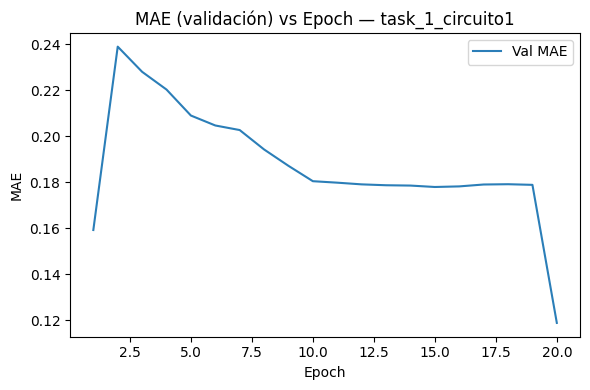

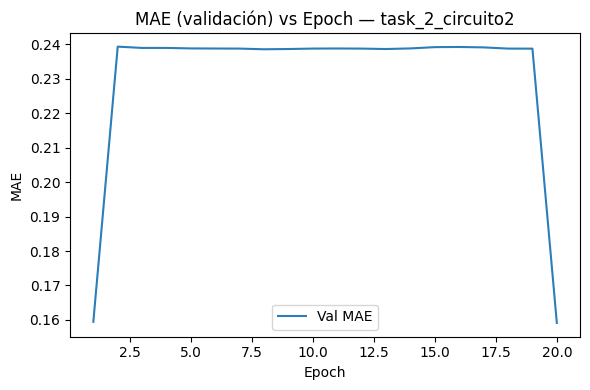

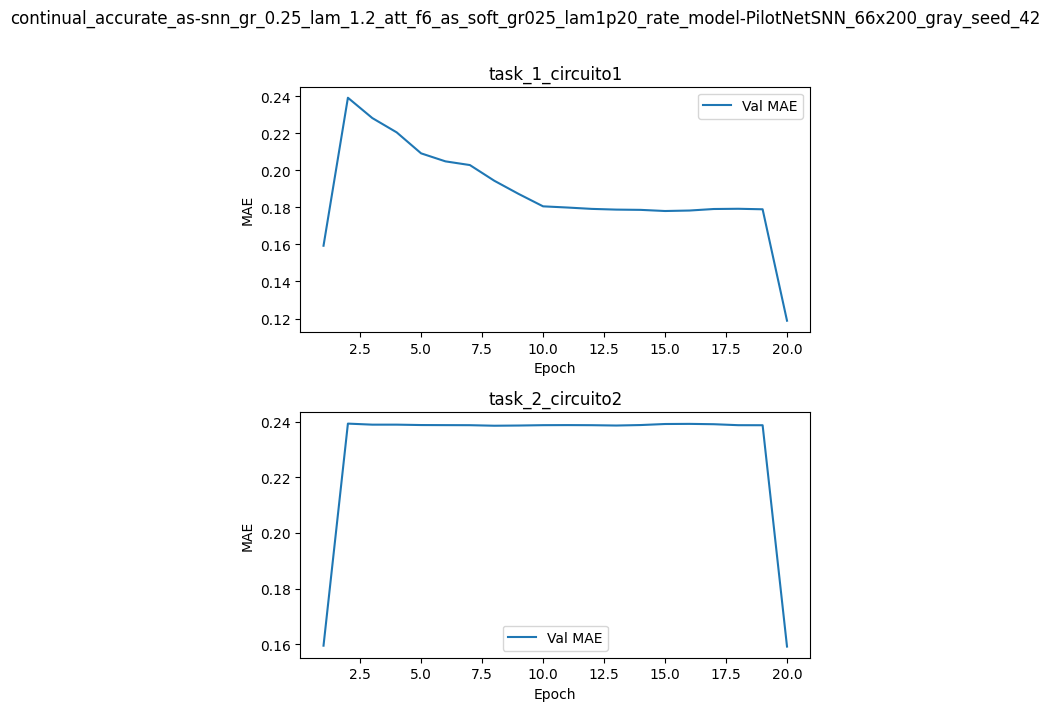

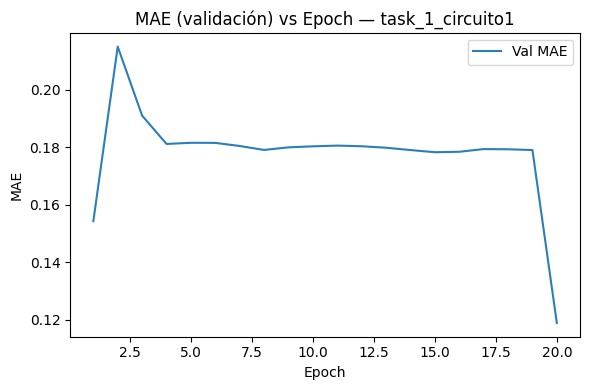

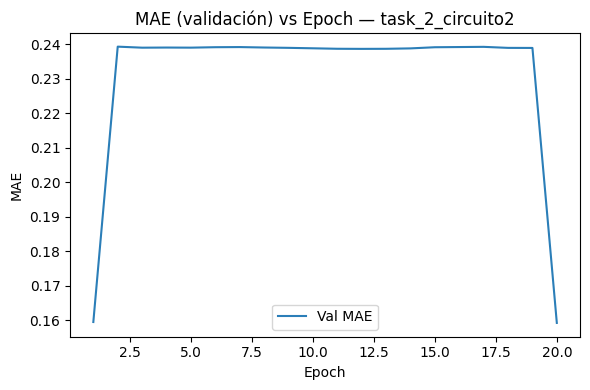

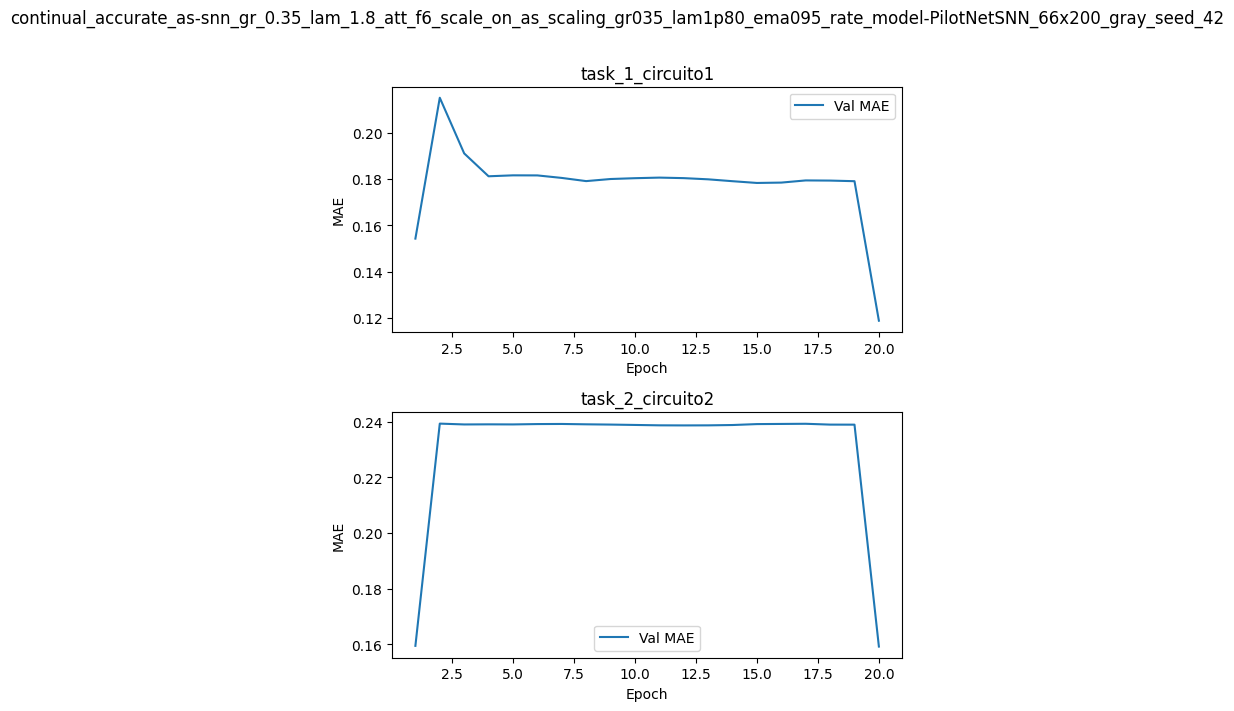

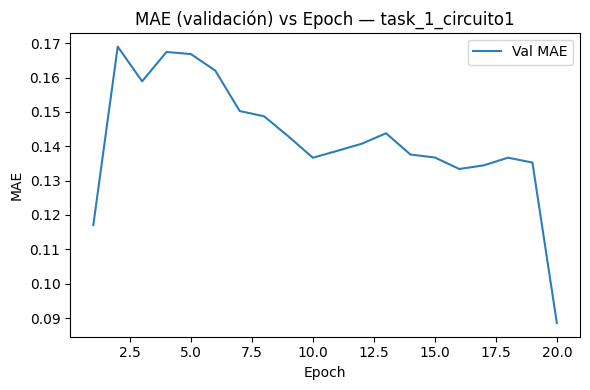

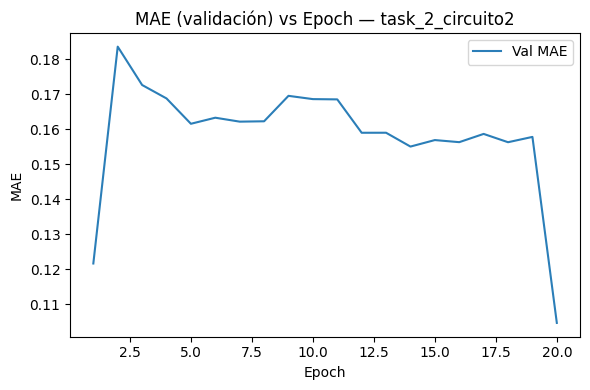

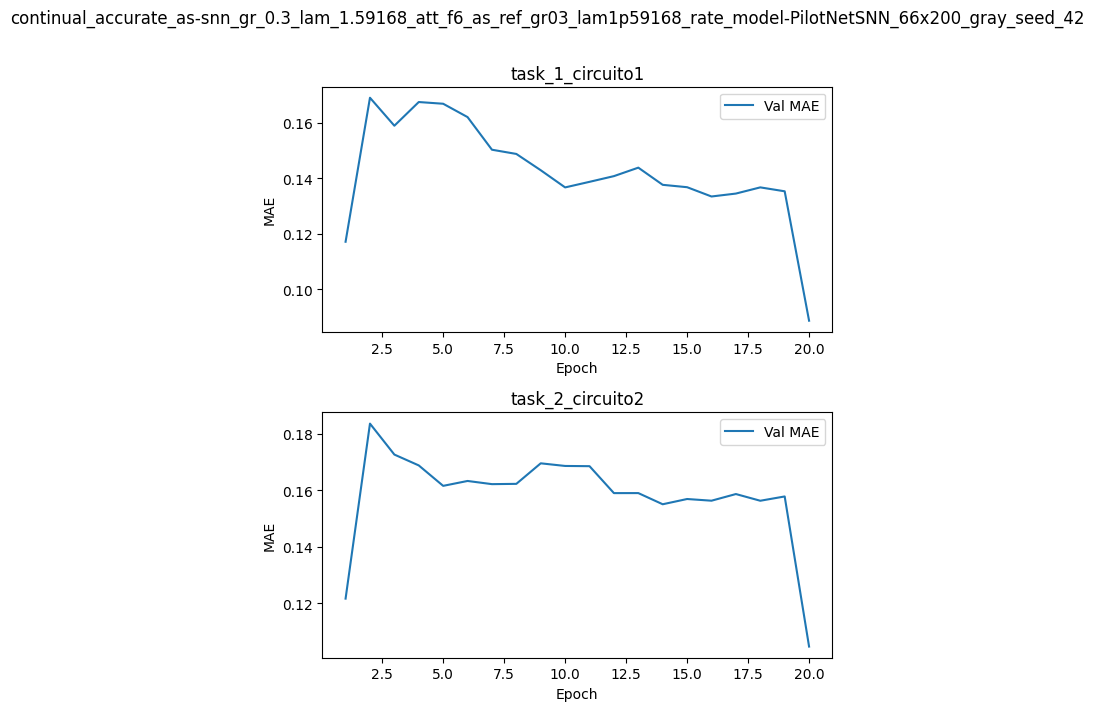

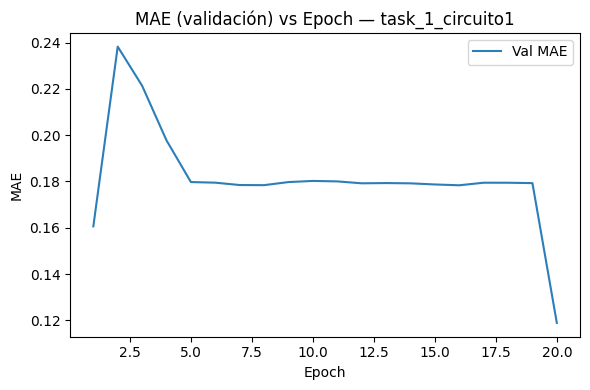

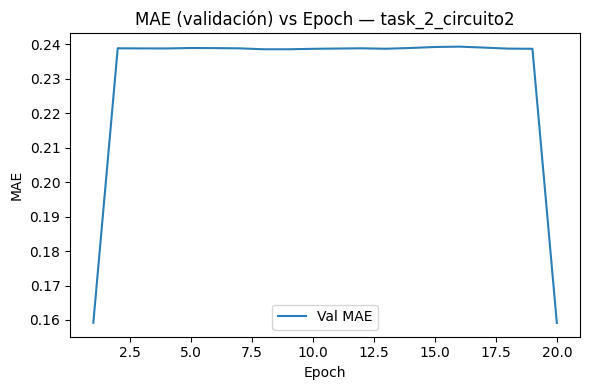

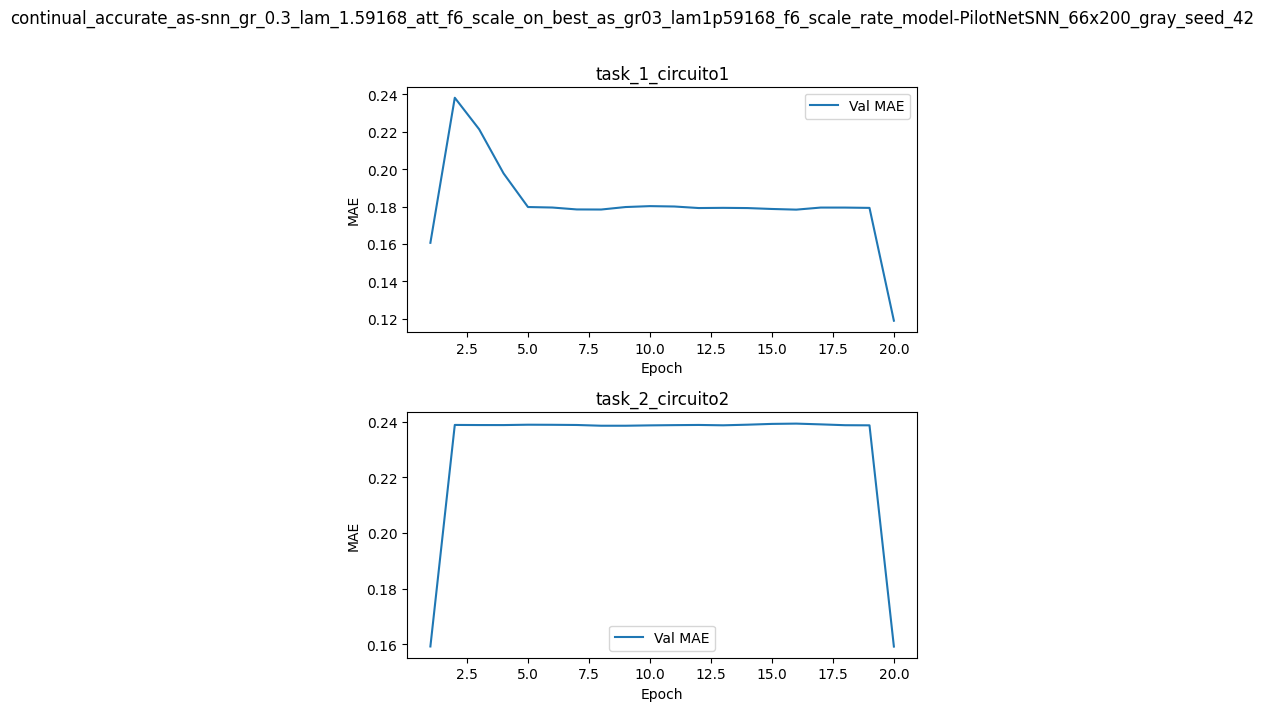

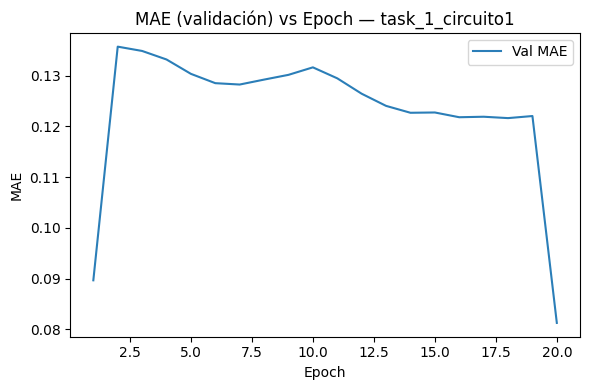

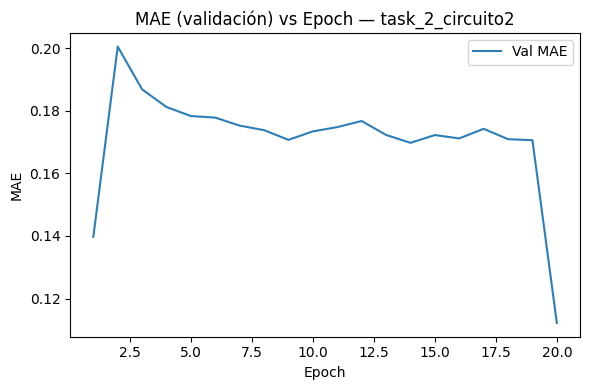

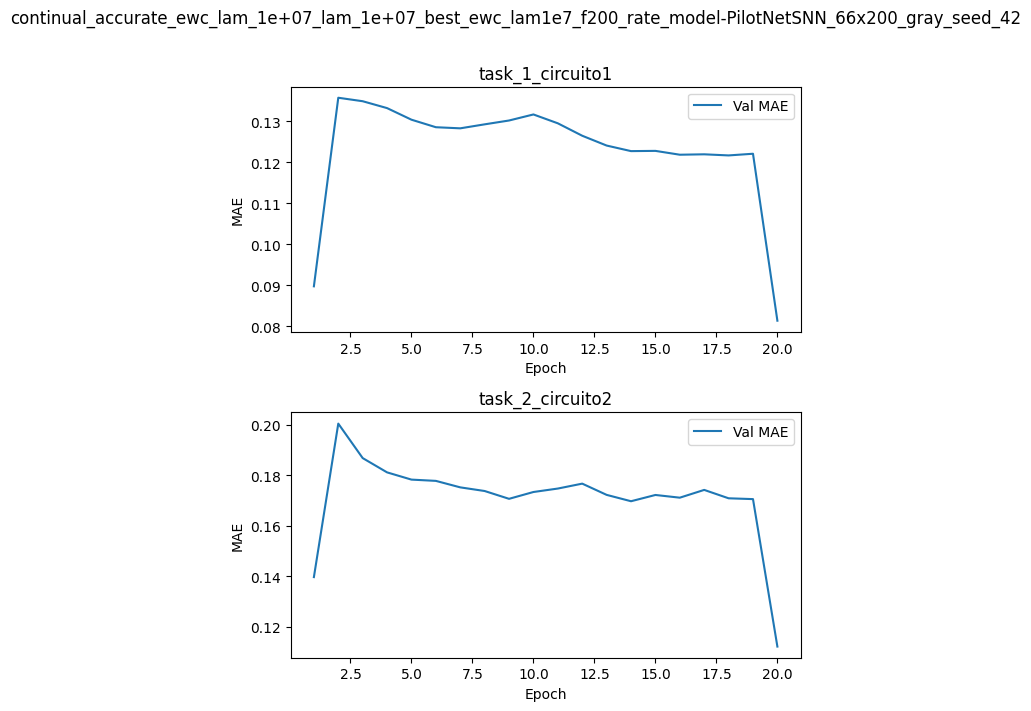

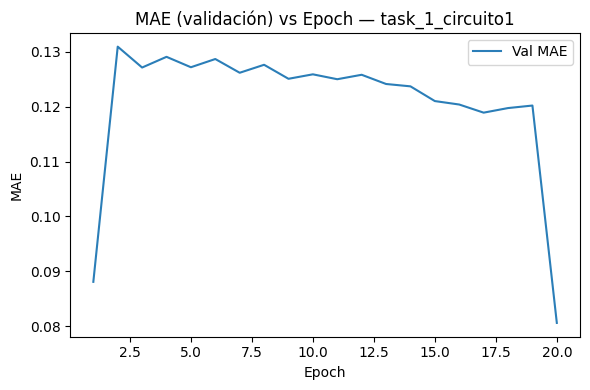

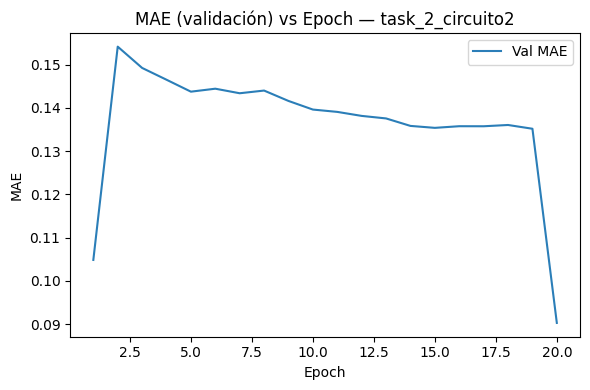

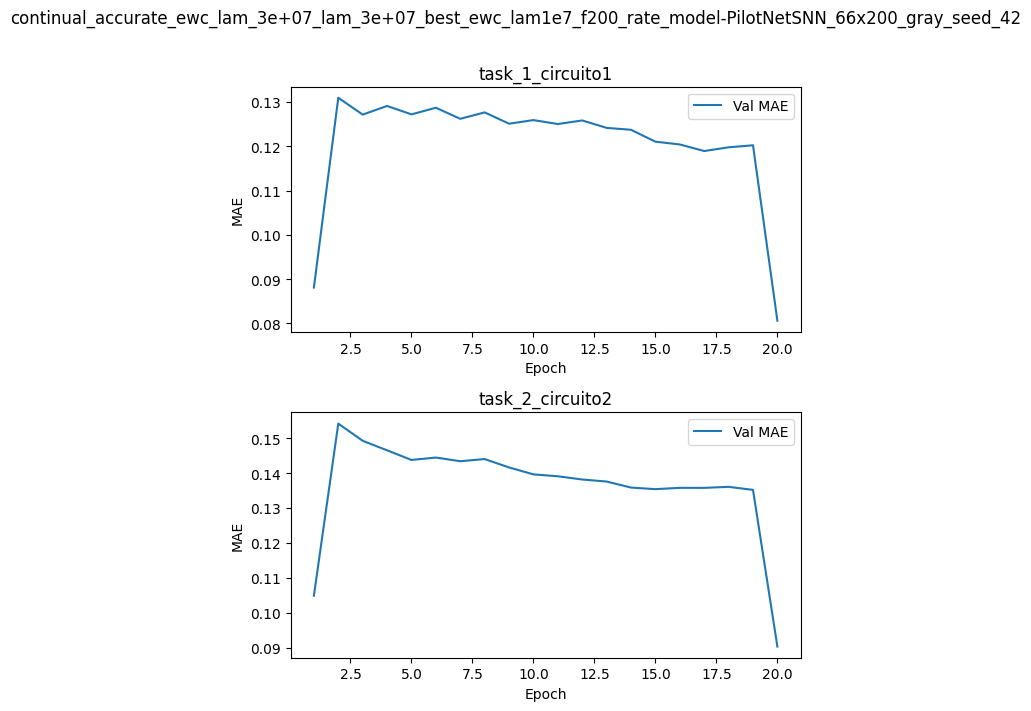

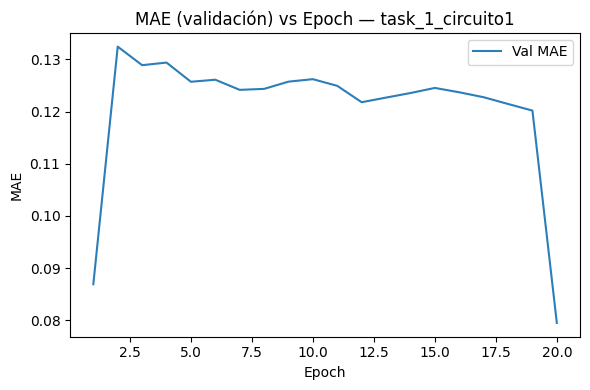

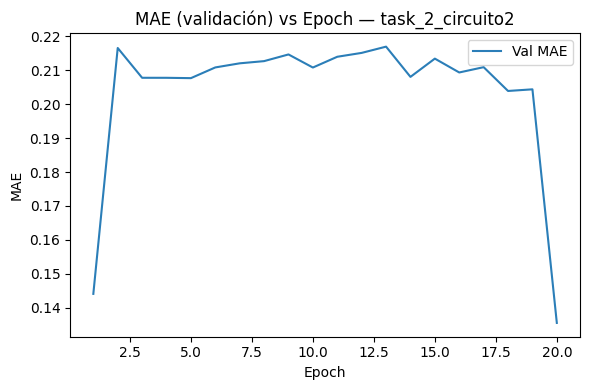

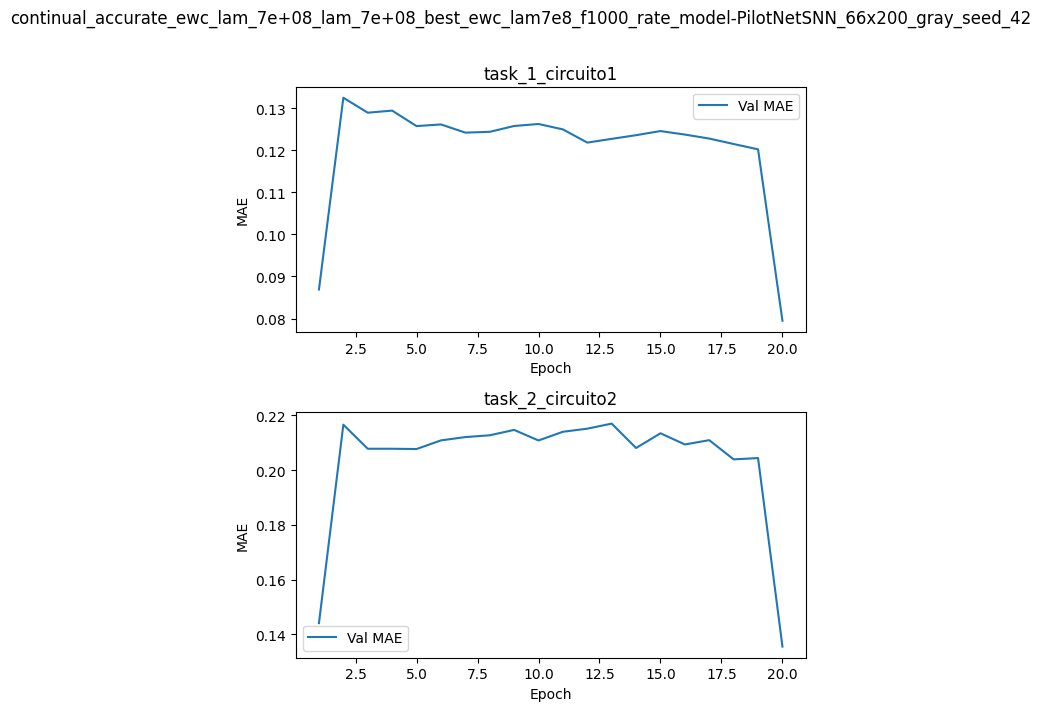

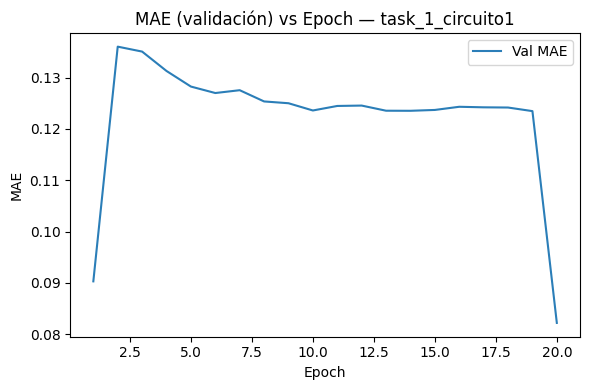

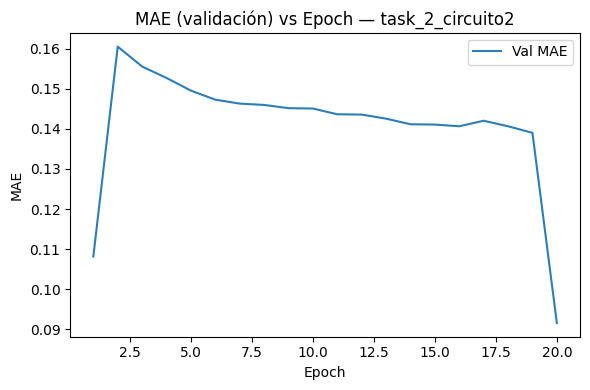

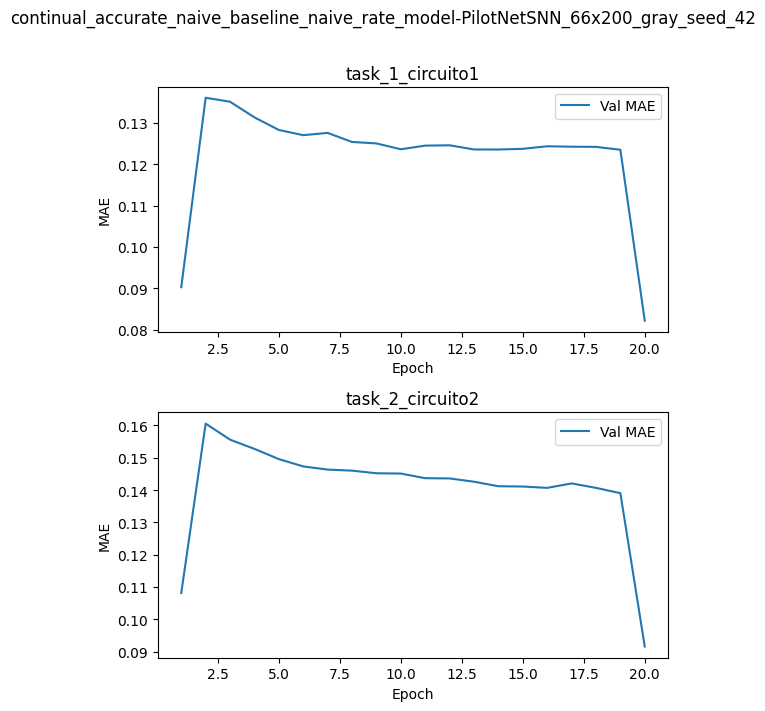

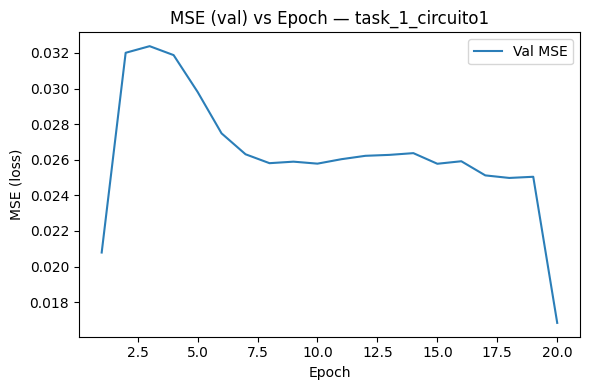

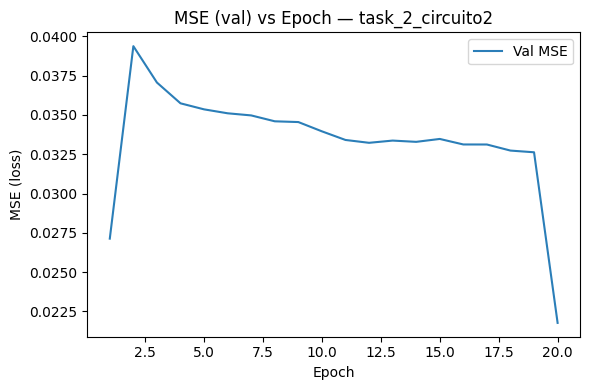

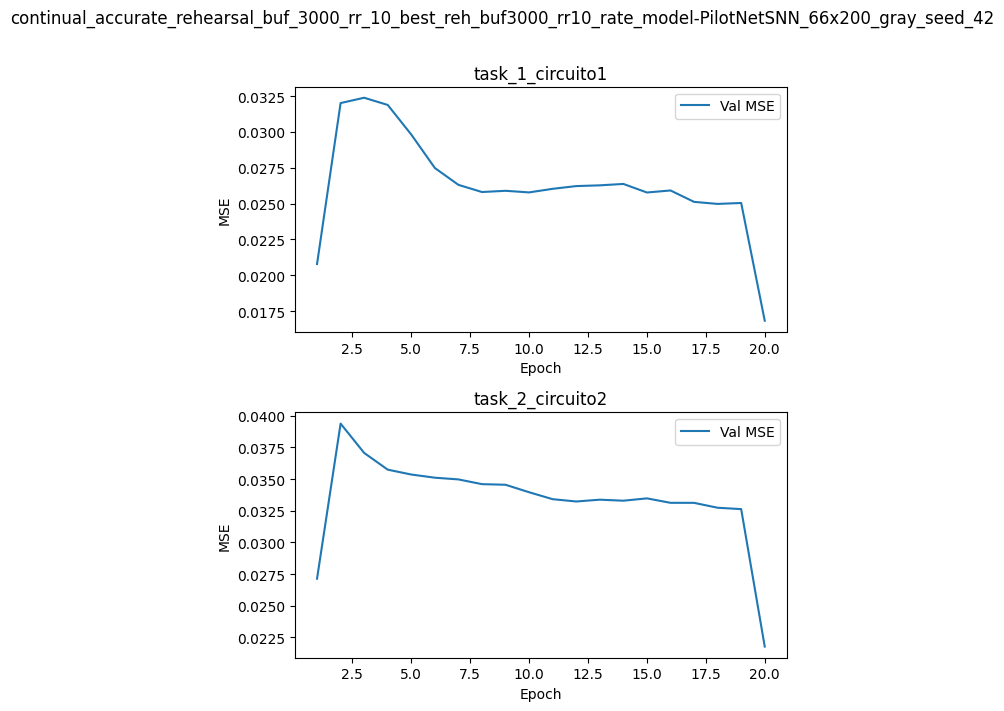

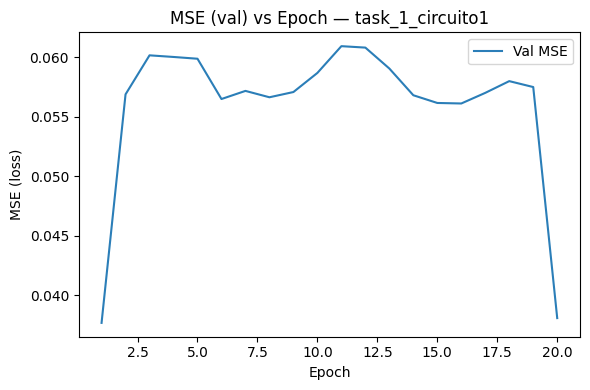

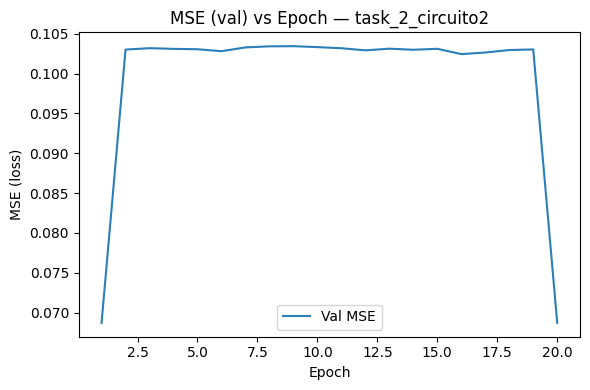

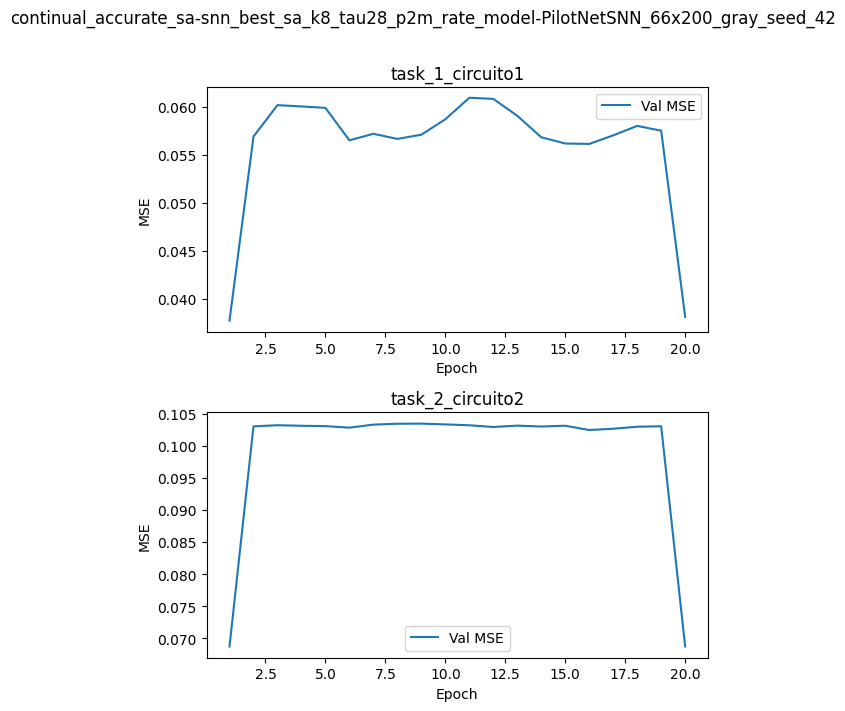

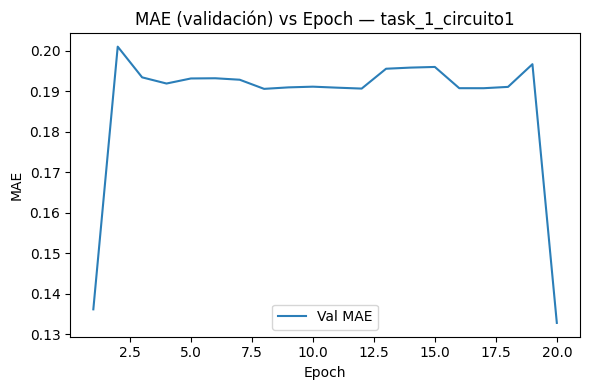

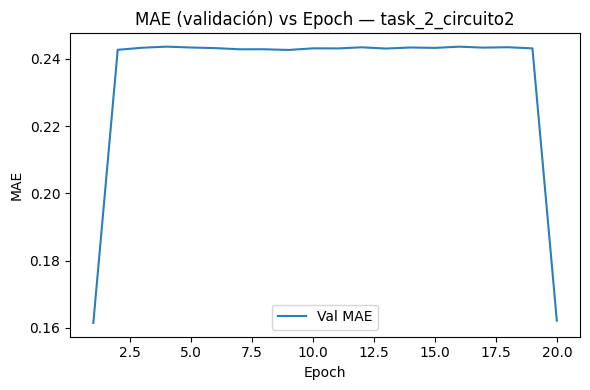

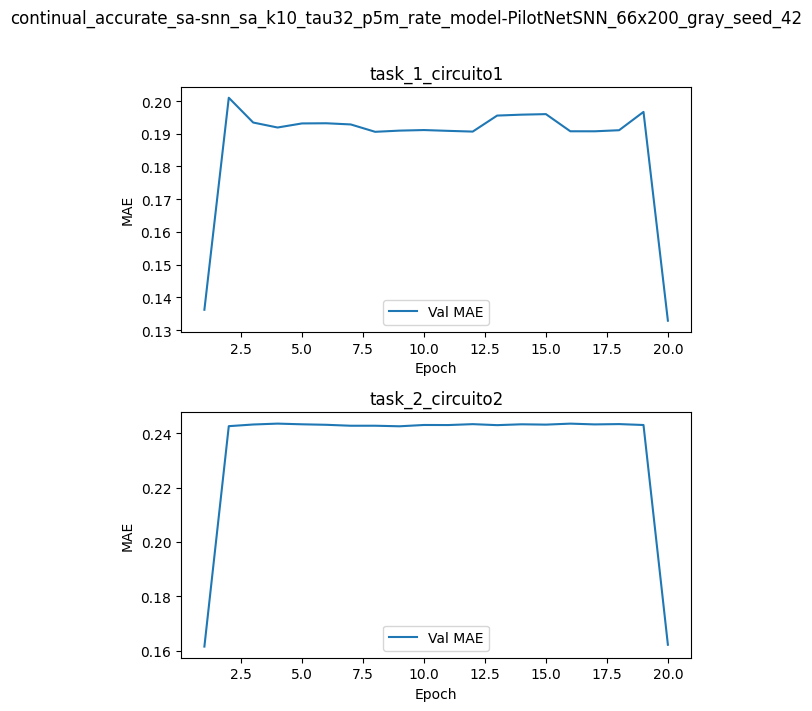

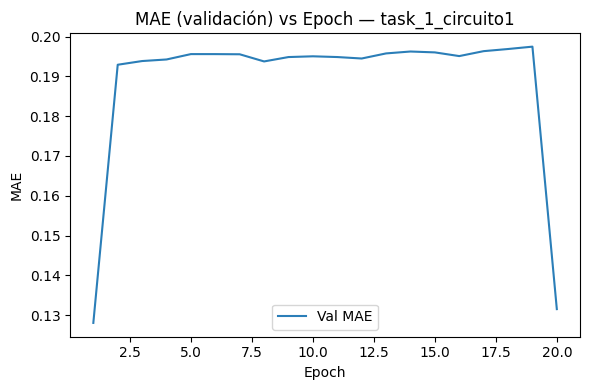

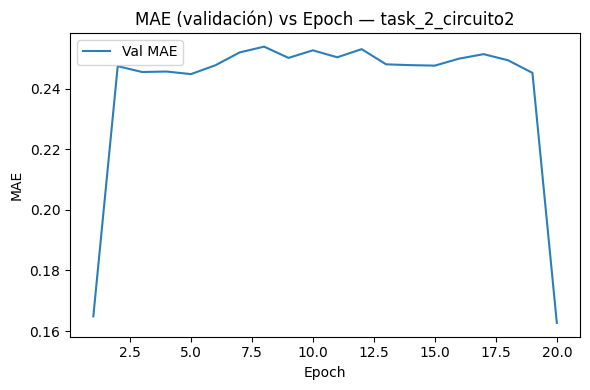

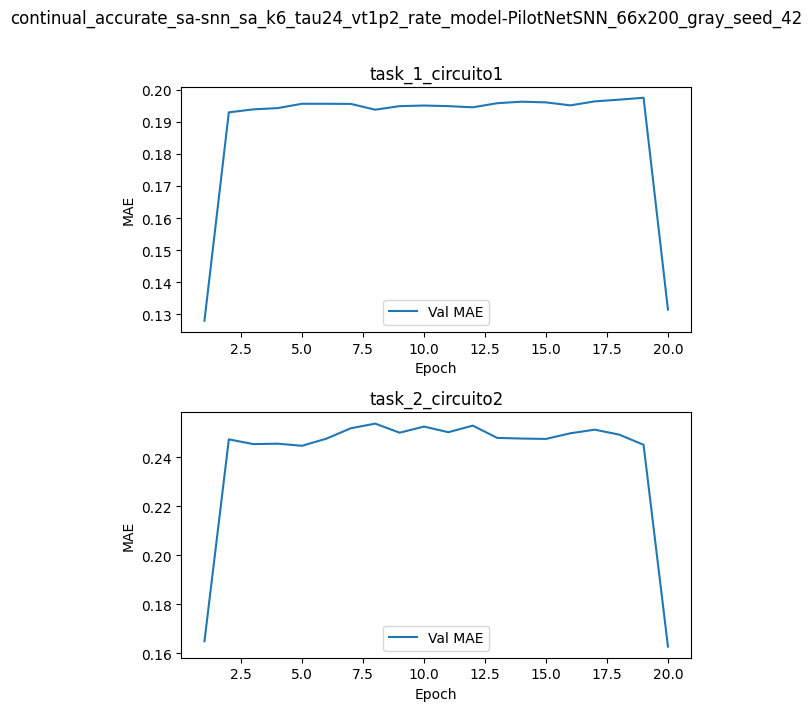

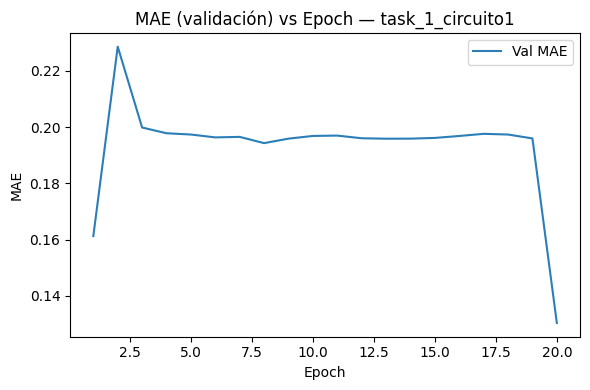

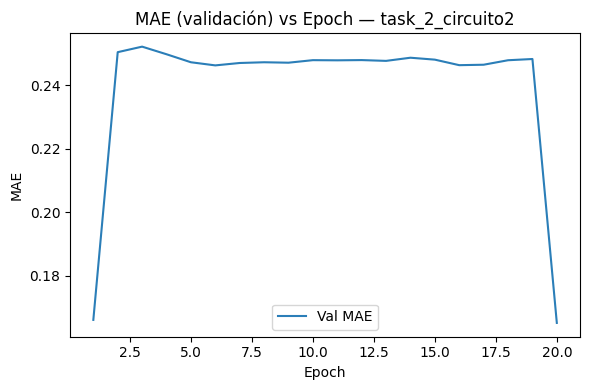

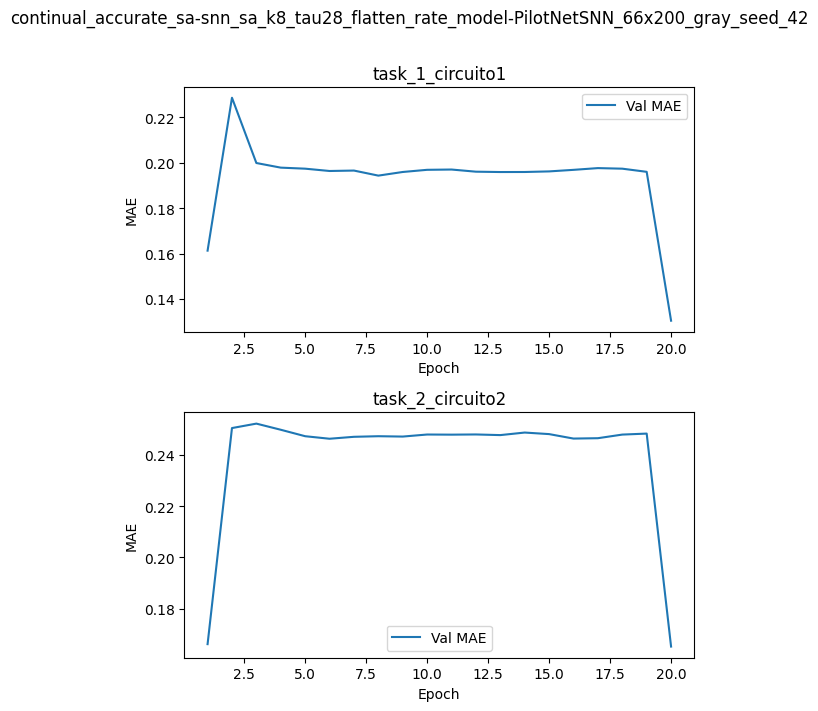

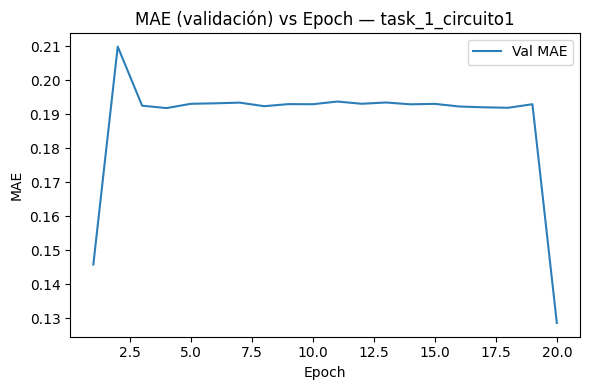

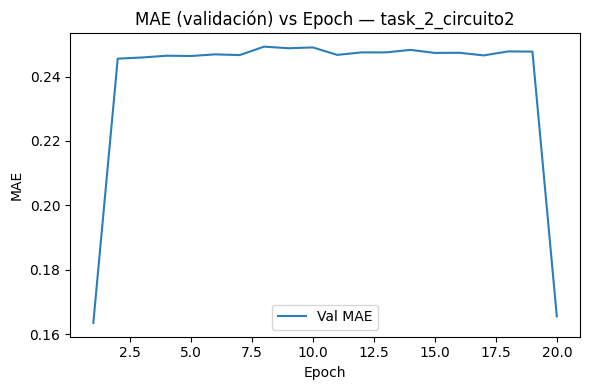

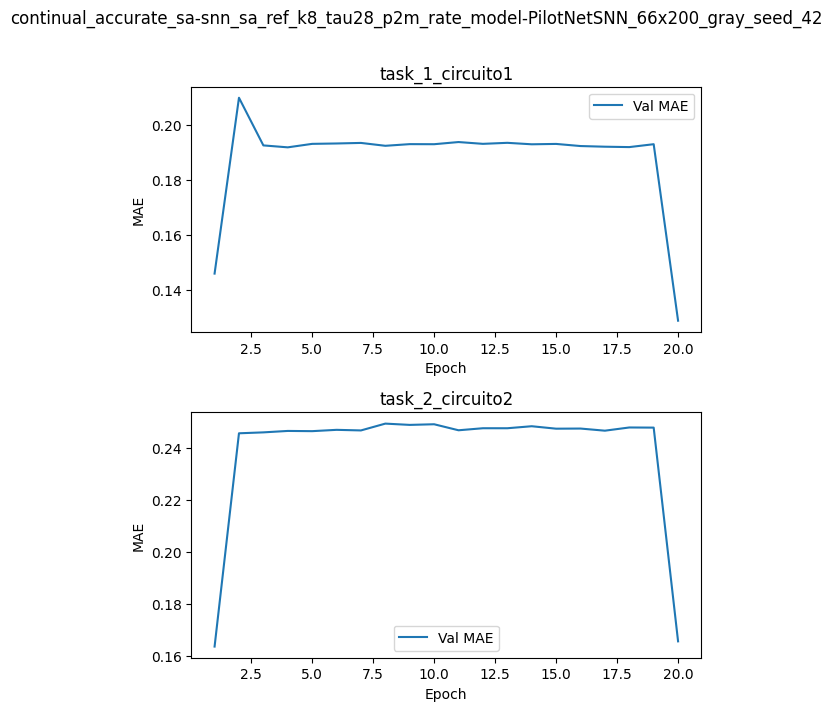

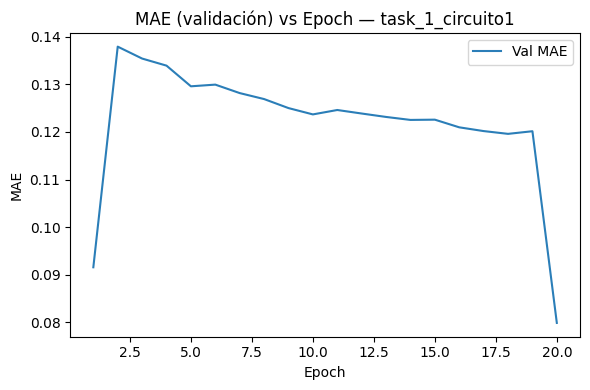

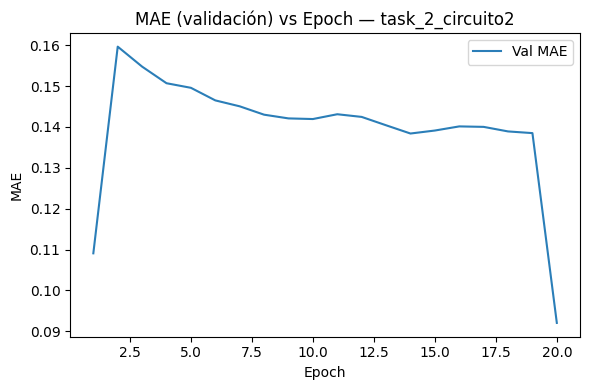

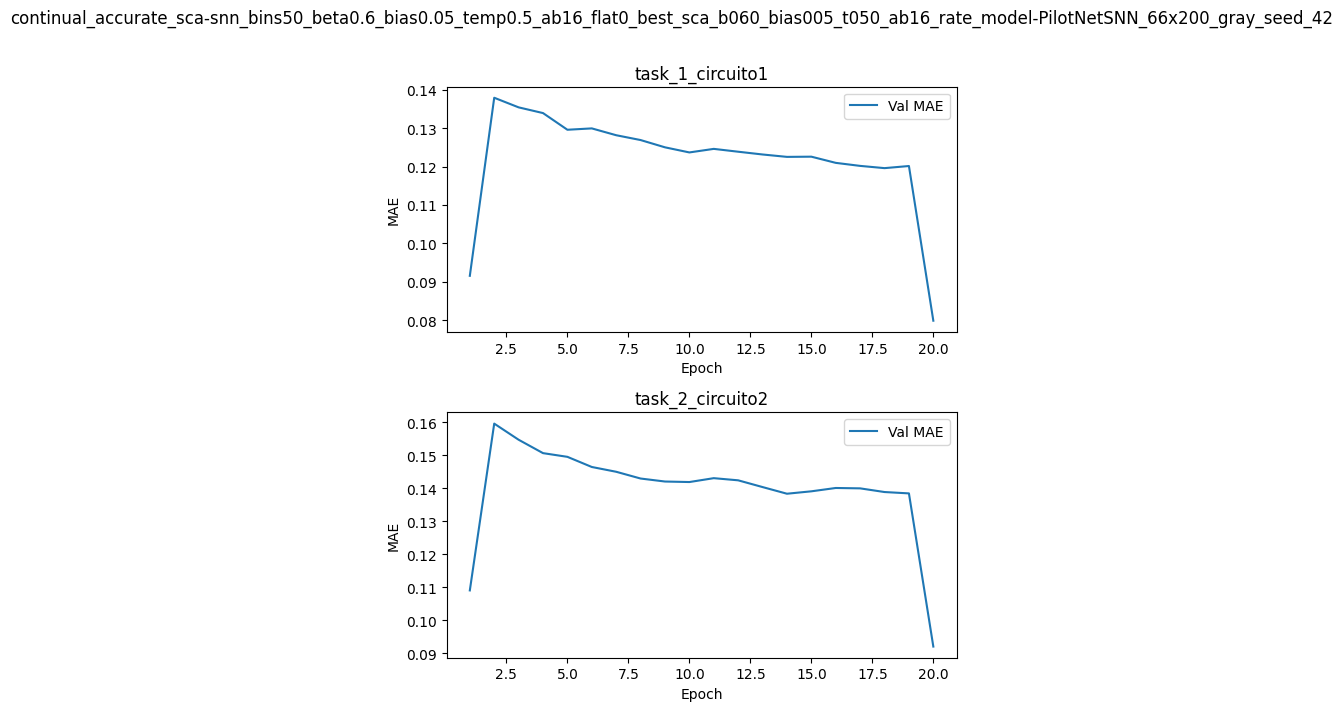

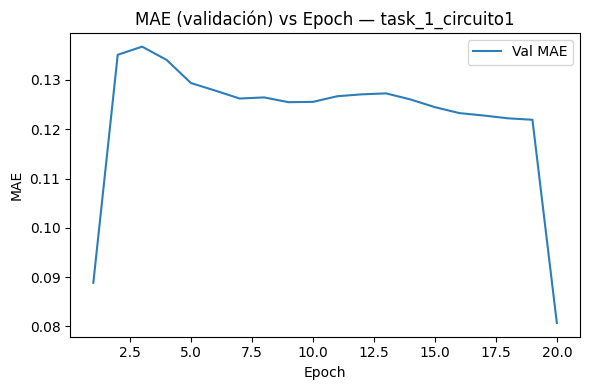

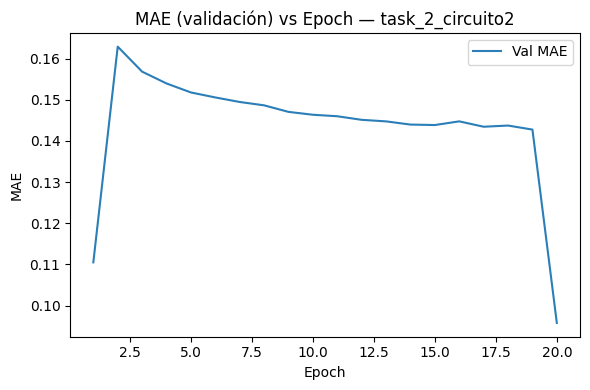

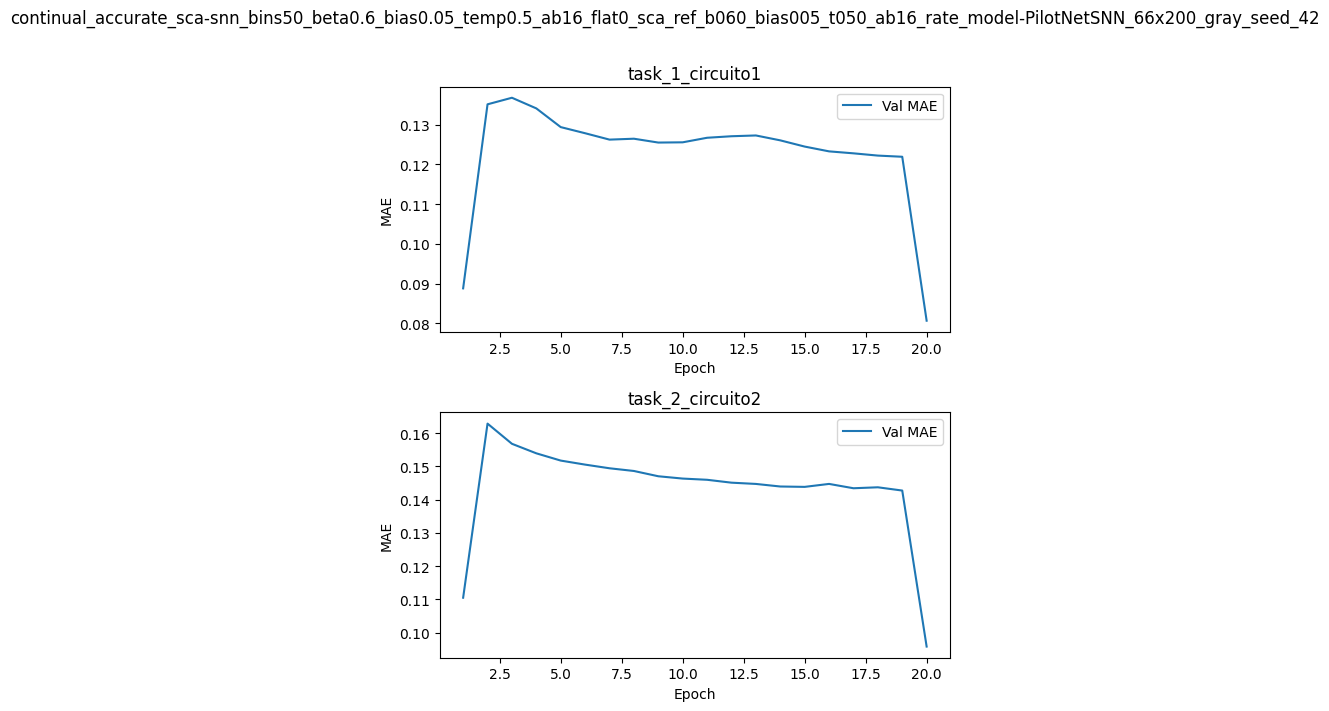

[OK] Curvas por run → /home/cesar/proyectos/TFM_SNN/outputs/summary/paper_set_accurate_2025-11-03/plots_val_metrics


/home/cesar/proyectos/TFM_SNN/src/plots.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


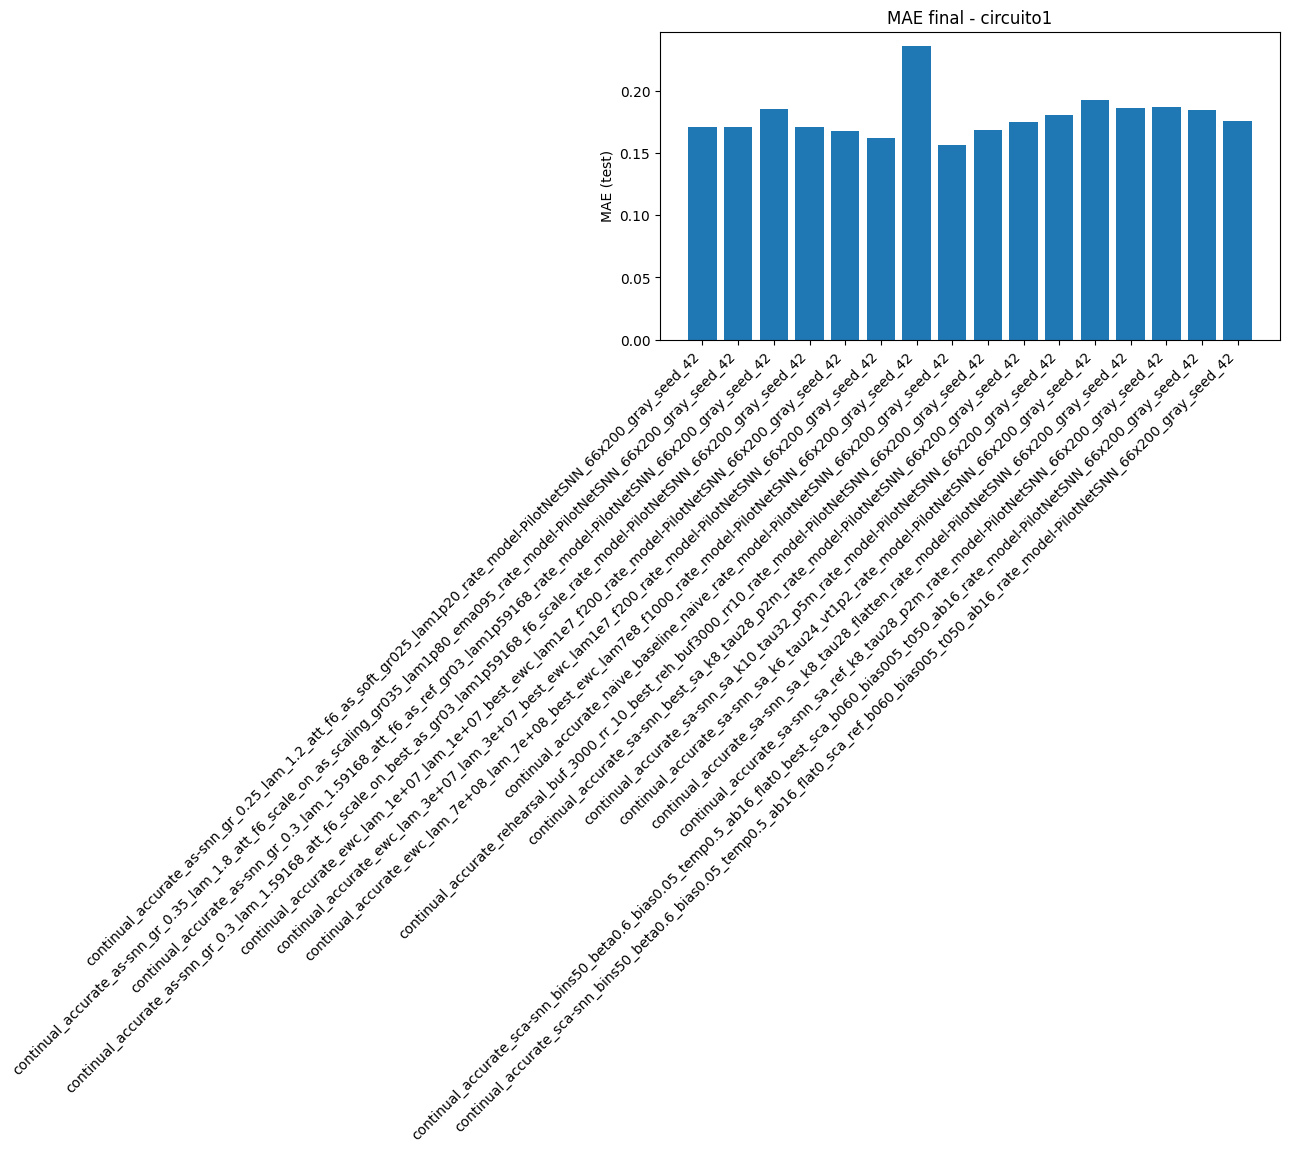

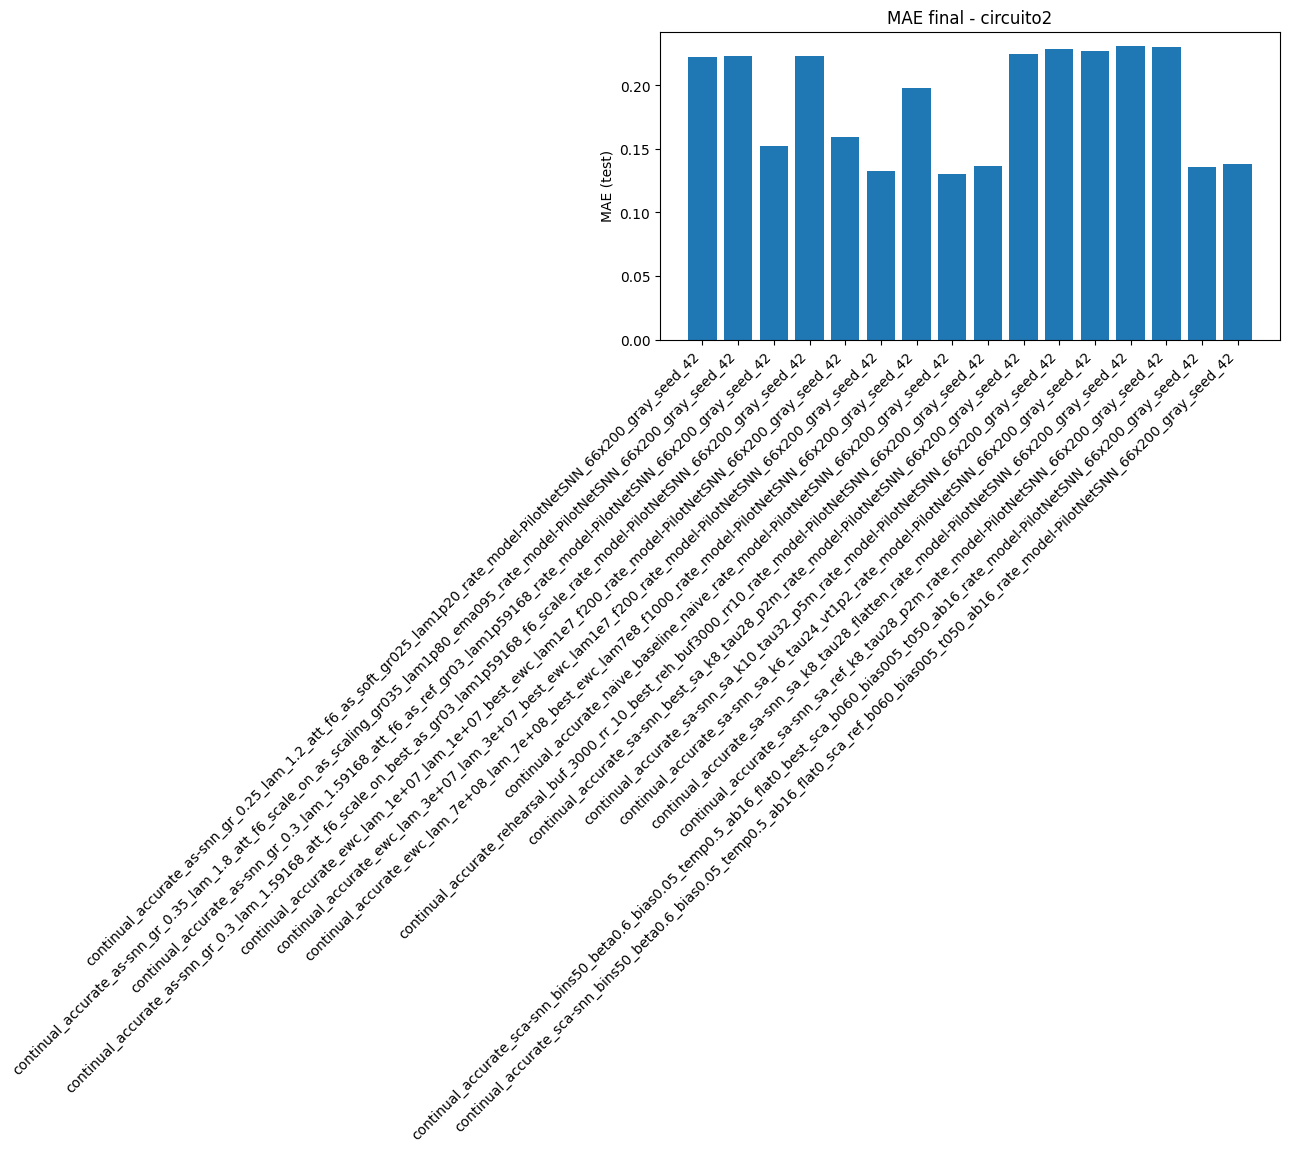

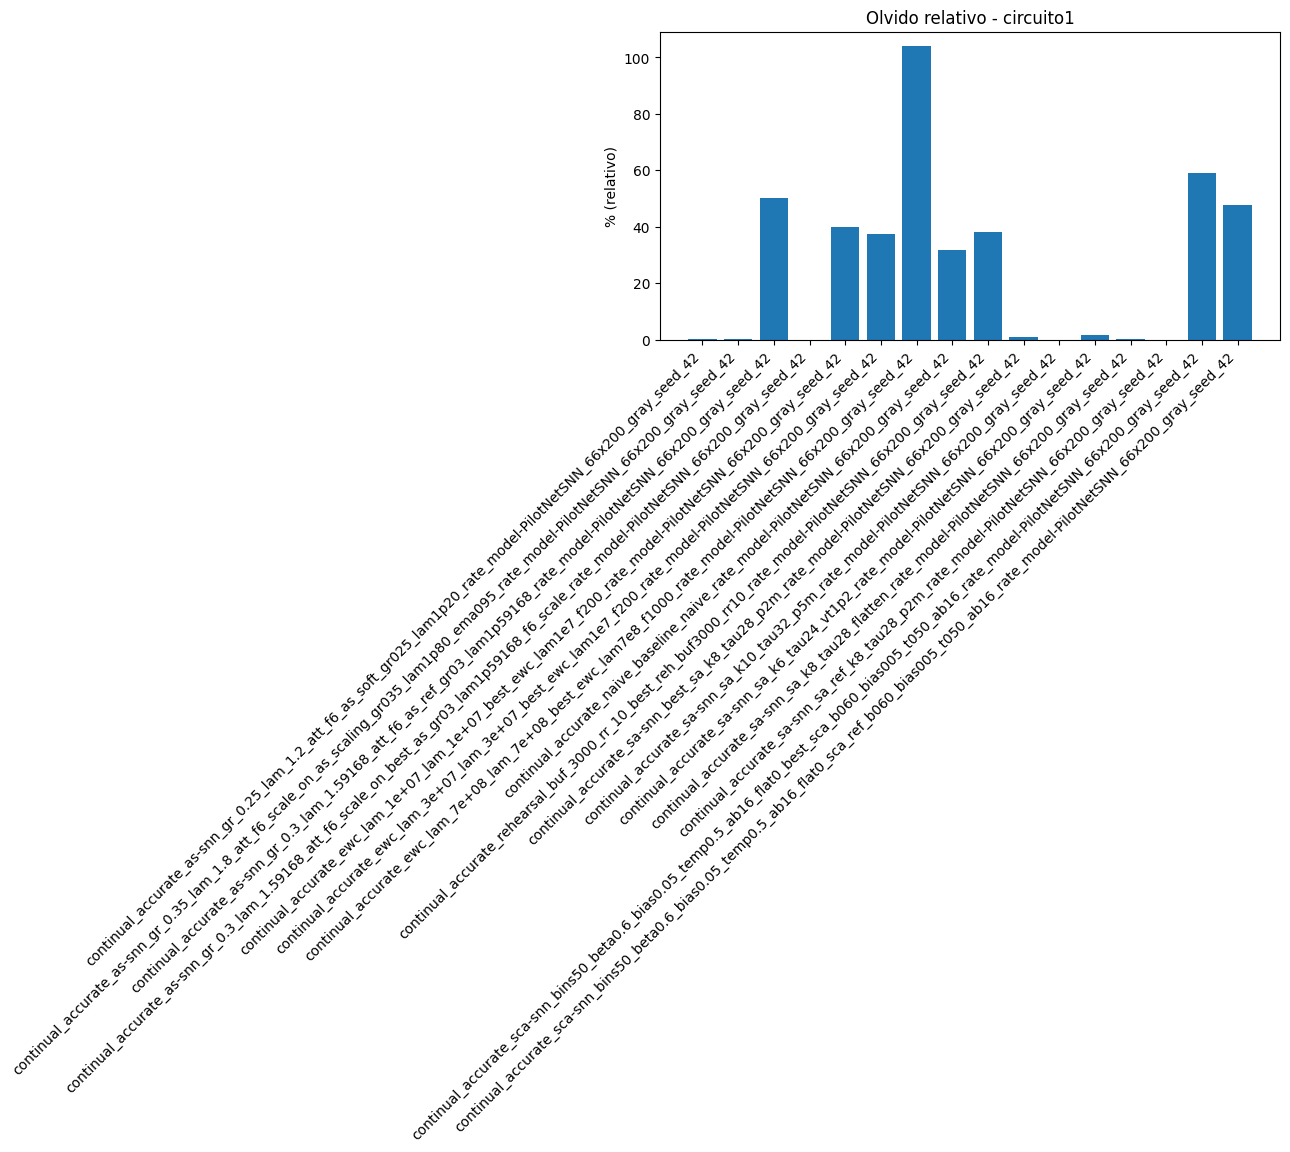

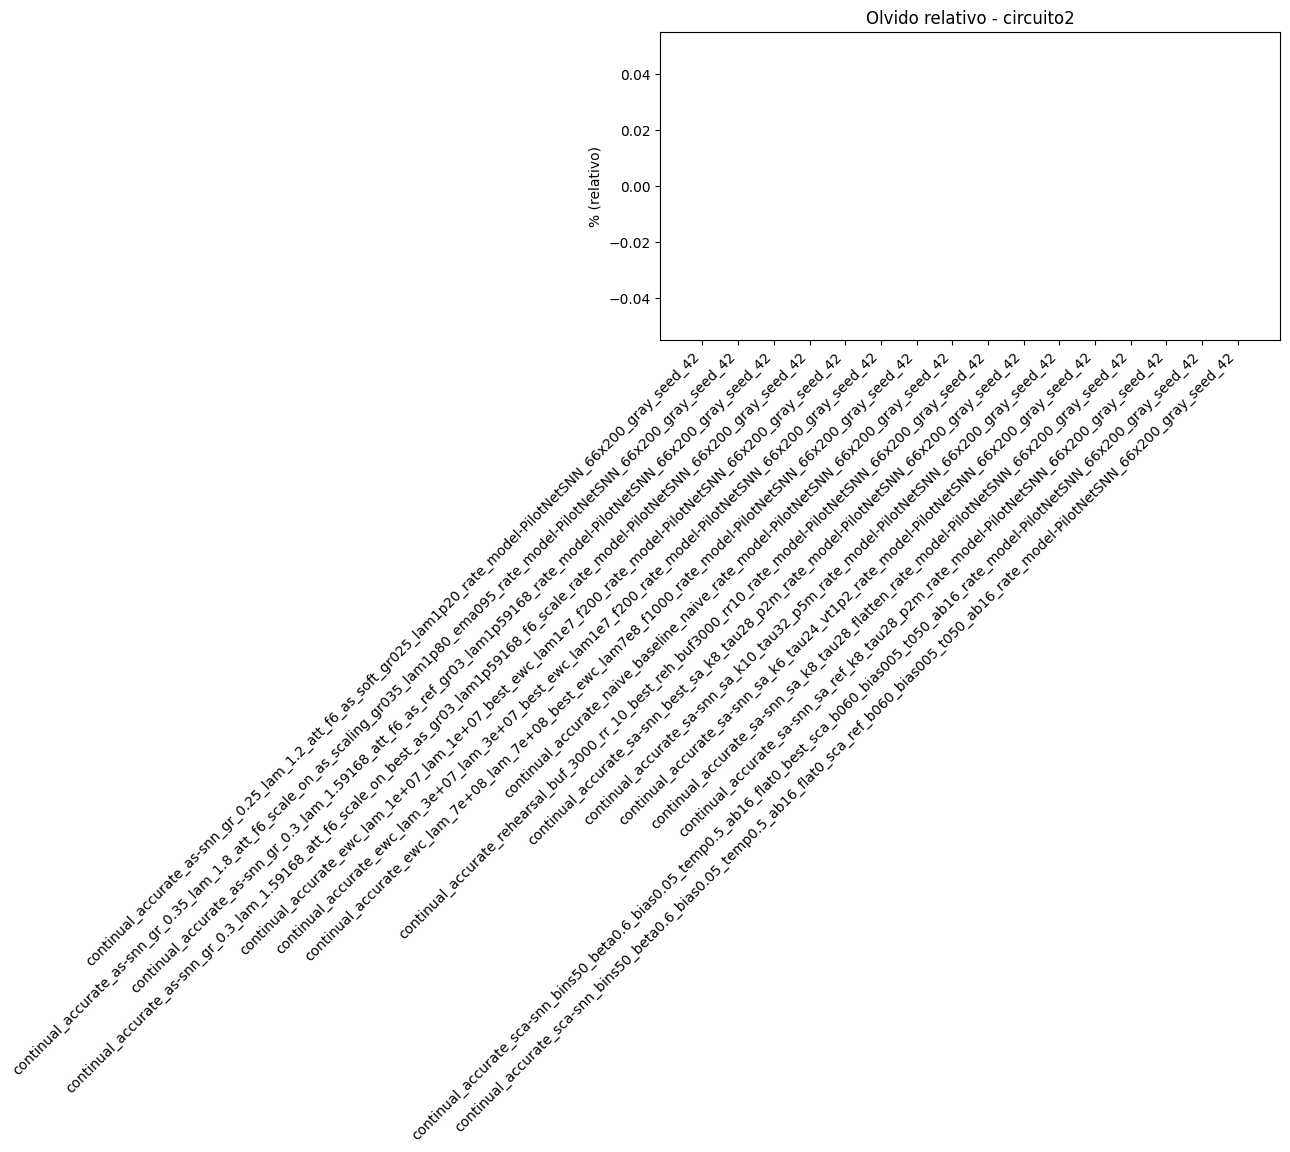

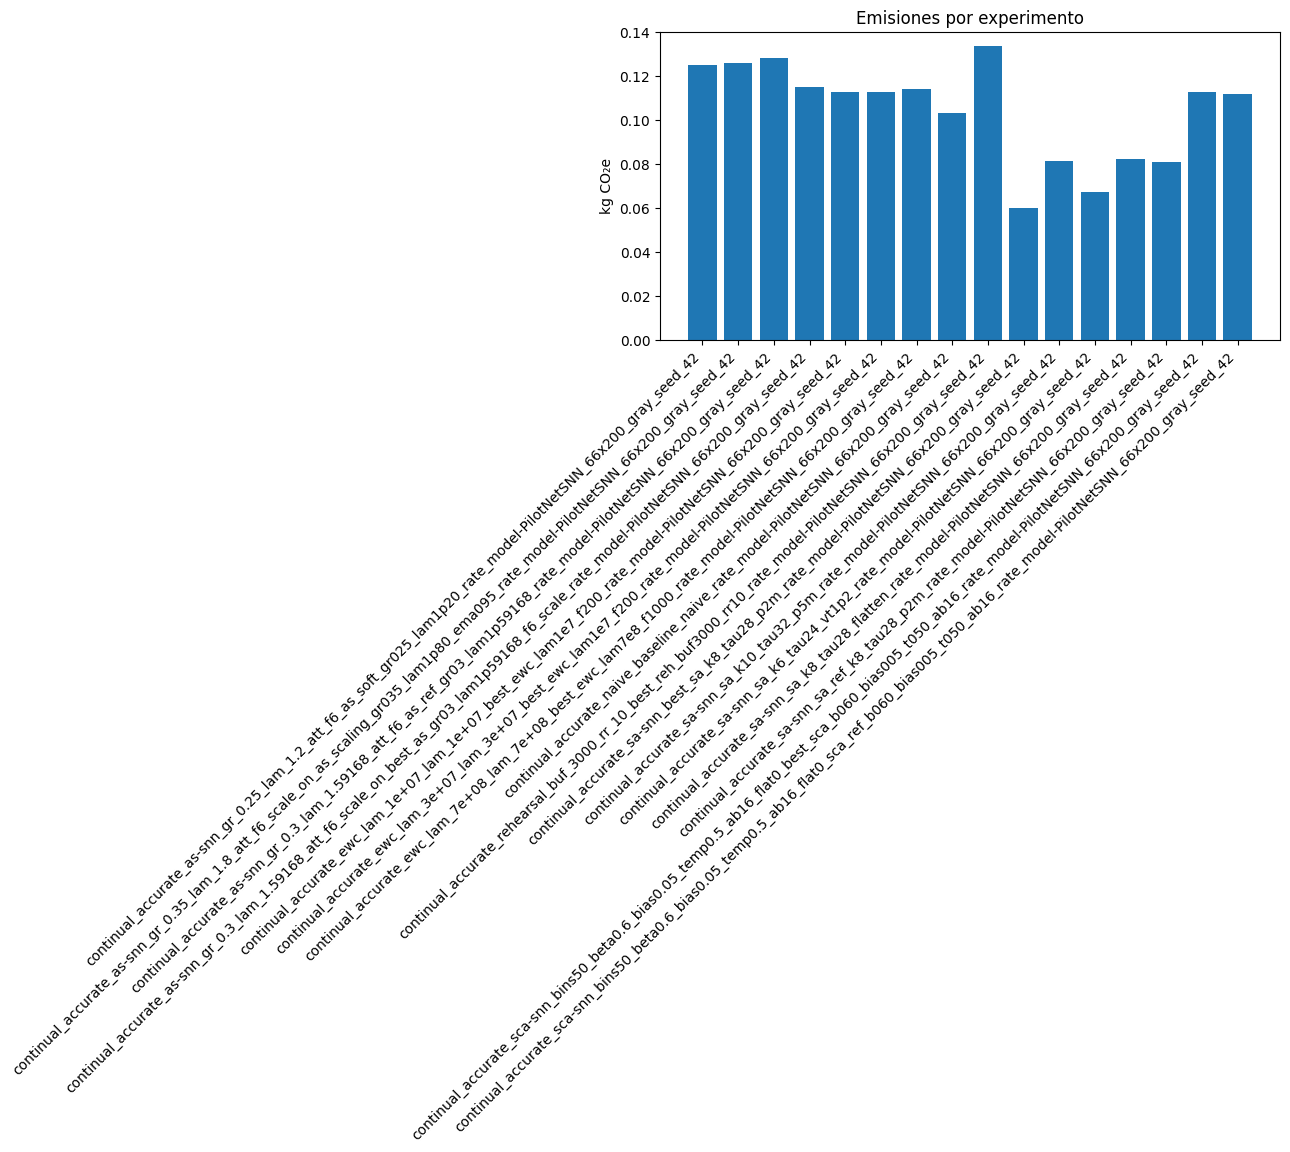

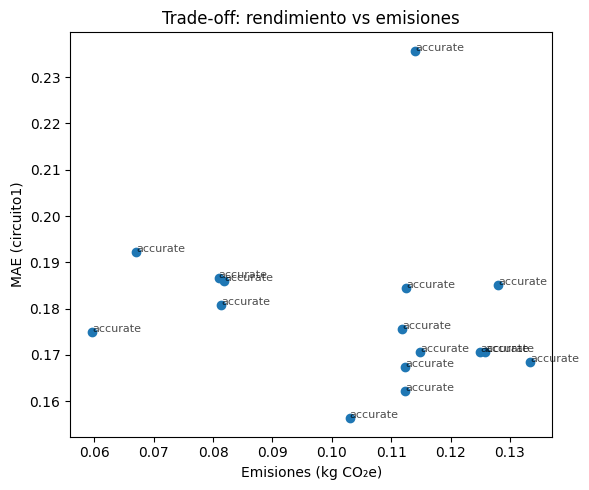

[OK] plot_across_runs → /home/cesar/proyectos/TFM_SNN/outputs/summary/paper_set_accurate_2025-11-03/plots_across_runs


In [9]:
# Celda 6 — Curvas por run y “across runs”
try:
    from src.plots import plot_across_runs, plot_mae_curves_for_run as plot_loss_curves_for_run
except Exception:
    plot_across_runs = None
    plot_loss_curves_for_run = None

# Curvas por run (val_loss/val_mae), restringido a la selección
if plot_loss_curves_for_run is not None:
    base_plots = THIS_SUMMARY / "plots_val_metrics"
    base_plots.mkdir(parents=True, exist_ok=True)
    for rd in sorted(set(df_sel["run_dir"].astype(str))):
        try:
            plot_loss_curves_for_run(_abs_run_dir(rd), base_plots, smooth_window=3)
        except Exception as e:
            print(f"[WARN] Falló curvas en {Path(rd).name}: {e}")
    print("[OK] Curvas por run →", base_plots)
else:
    # Fallback sencillo: lee task_*/loss_curves.csv y dibuja val_mae si existe
    base_plots = THIS_SUMMARY / "plots_val_metrics_fallback"
    base_plots.mkdir(parents=True, exist_ok=True)
    for rd in sorted(set(df_sel["run_dir"].astype(str))):
        rdp = _abs_run_dir(rd)
        for t in sorted(rdp.glob("task_*")):
            dfc = _read_csv_silent(t / "loss_curves.csv")
            if isinstance(dfc, pd.DataFrame) and "val_mae" in dfc.columns:
                fig, ax = plt.subplots(figsize=(7,4))
                ax.plot(dfc["val_mae"].values)
                ax.set_title(f"{rd} / {t.name} — val_mae")
                ax.set_xlabel("epoch")
                ax.set_ylabel("val_mae ↓")
                ax.grid(True, alpha=0.3)
                fig.tight_layout()
                outp = base_plots / f"{rd}_{t.name}_val_mae.png"
                fig.savefig(outp, dpi=150)
                plt.close(fig)
    print("[OK] Curvas por run (fallback) →", base_plots)

# Barras y trade-offs “across runs”, restringido a la selección
if plot_across_runs is not None:
    dest_acc = THIS_SUMMARY / "plots_across_runs"
    dest_acc.mkdir(parents=True, exist_ok=True)
    try:
        plot_across_runs(df_sel, dest_acc)
        print("[OK] plot_across_runs →", dest_acc)
    except Exception as e:
        print("[WARN] plot_across_runs falló:", e)
else:
    print("[INFO] plot_across_runs no disponible; saltando.")


In [10]:
# Celda EXTRA — Sanidad rápida (opcional)

def sanity(df):
    print("## SANITY ##")
    cols = [c for c in df.columns if re.match(r"^circuito[0-9]+_(final_mae|best_mae|forget_abs|forget_rel)$", c)]
    for c in cols + ["avg_forget_rel", "emissions_kg"]:
        if c in df.columns:
            print(f"{c:26s}  NaN={int(df[c].isna().sum())}  min={pd.to_numeric(df[c], errors='coerce').min()}  max={pd.to_numeric(df[c], errors='coerce').max()}")
    print("############")

print("---- df_all (merged) ----")
sanity(df_all)
print("---- df_sel (selección final) ----")
sanity(df_sel)

# ¿Qué runs seleccionados no tienen MAE final de última tarea?
missing_mae = df_sel[df_sel[MAE_COL].isna()]
if not missing_mae.empty:
    print("\n[INFO] Runs sin MAE final (última tarea):")
    display(missing_mae[["run_dir","method_base","preset","encoder","seed","T","amp","batch_size"]].head(20))
else:
    print("\n[OK] Todos los runs seleccionados tienen MAE final.")


---- df_all (merged) ----
## SANITY ##
circuito1_best_mae          NaN=10  min=0.1078024624674615  max=0.1893877407892276
circuito1_final_mae         NaN=10  min=0.11259287090218578  max=0.27540107380458745
circuito1_forget_abs        NaN=10  min=0.0  max=0.1483580463006605
circuito1_forget_rel        NaN=10  min=0.0  max=1.196449761398264
circuito2_best_mae          NaN=10  min=0.1298991935483871  max=0.23124650421962945
circuito2_final_mae         NaN=10  min=0.1298991935483871  max=0.23124650421962945
circuito2_forget_abs        NaN=10  min=0.0  max=0.0
circuito2_forget_rel        NaN=10  min=0.0  max=0.0
avg_forget_rel              NaN=10  min=0.0  max=0.598224880699132
emissions_kg                NaN=46  min=0.0003700506629211  max=0.2177446649646786
############
---- df_sel (selección final) ----
## SANITY ##
circuito1_best_mae          NaN=0  min=0.11560512904432392  max=0.1893877407892276
circuito1_final_mae         NaN=0  min=0.1562704553955489  max=0.23572213390686367
circuit

Celda 7 — Auditoría rápida (por qué se excluye algo)

In [11]:
# Celda 7 — Auditoría de exclusiones (opcional)

def audit_exclusions(df_all, df_sel):
    used = set(df_sel["run_dir"])
    cand = df_all.copy()
    cand["in_selection"] = cand["run_dir"].isin(used)
    excl = cand[~cand["in_selection"]].copy()
    if excl.empty:
        print("[AUDIT] No hay excluidos.")
        return
    cols = ["run_dir","preset","method_base","encoder","model","seed","T","amp","mtime_dt"]
    for c in cols:
        if c not in excl.columns:
            excl[c] = np.nan
    # Motivos típicos
    excl["fail_preset"] = PRESET_FILTER and (excl["preset"] != PRESET_FILTER)
    excl["fail_enc"]    = ENCODER_FILTER and (excl["encoder"] != ENCODER_FILTER)
    excl["fail_seed"]   = (SEED_FILTER is not None) & (excl["seed"] != SEED_FILTER)
    excl["fail_method"] = METHODS_KEEP and (~excl["method_base"].isin(METHODS_KEEP))
    excl["fail_newrun"] = ONLY_NEW_RUNNER and (excl.get("is_new_runner", False) != True)
    excl["fail_date"]   = (MTIME_FROM is not None) & (excl["mtime"] < MTIME_FROM.timestamp())
    excl["fail_tag"]    = bool(TAG_INCLUDE_SUBSTR) and ~excl["run_dir"].astype(str).apply(lambda s: any(t in s for t in TAG_INCLUDE_SUBSTR))
    excl["fail_whitelist"] = bool(RUN_DIR_WHITELIST) and ~excl["run_dir"].isin(RUN_DIR_WHITELIST)

    if STRICT_CFG:
        model_ok = excl["model"].astype(str).str.contains(MODEL_MATCH_SUBSTR, na=False)
        T_ok     = (pd.to_numeric(excl["T"], errors="coerce") == T_TARGET)
        amp_ok   = excl["amp"].astype(str).str.lower().isin(["true","1","yes"]) if AMP_REQUIRED else True
        excl["fail_model"] = ~model_ok
        excl["fail_T"]     = ~T_ok
        excl["fail_amp"]   = ~(amp_ok if isinstance(amp_ok, pd.Series) else True)
    display(excl[cols + [c for c in excl.columns if c.startswith("fail_")]].head(20))

audit_exclusions(df_all, df_sel)

run_dir    preset  \
2   continual_accurate_as-snn_gr_0.3_lam_1.59168_r...  accurate   
5   continual_accurate_as-snn_gr_0.3_lam_1.6_grid0...  accurate   
9   continual_accurate_ewc_lam_7e+08_lam_7e+08_gri...  accurate   
10  continual_accurate_ewc_lam_7e+08_lam_7e+08_rat...  accurate   
12  continual_accurate_naive_grid01_rate_model-Pil...  accurate   
13  continual_accurate_naive_rate_model-PilotNetSN...  accurate   
15  continual_accurate_rehearsal_buf_3000_rr_10_ra...  accurate   
16  continual_accurate_rehearsal_buf_3000_rr_20_ra...  accurate   
17  continual_accurate_rehearsal_buf_3000_rr_20+ew...  accurate   
23  continual_accurate_sa-snn_k6_tau42_th1-2_p7000...  accurate   
24  continual_accurate_sa-snn_k8_tau28_th1-2_p2000...  accurate   
25  continual_accurate_sa-snn_k8_tau28_th1-2_p2000...  accurate   
26  continual_accurate_sa-snn_k8_tau30_th1-2_p5000...  accurate   
27  continual_accurate_sa-snn_k8_tau32_th1-2_p5000...  accurate   
28  continual_accurate_sa-snn_k9_tau28_th1-2_p5000...  accurate   
29  continual_accurate_sca-snn_bins50_beta0.65_bia...  accurate   
30  continual_accurate_sca-snn_bins50_beta0.65_bia...  accurate   
31  continual_accurate_sca-snn_bins50_beta0.65_bia...  accurate   
32  continual_accurate_sca-snn_bins50_beta0.65_bia...  accurate   
33  continual_accurate_sca-snn_bins50_beta0.65_bia...  accurate   

      method_base encoder                    model  seed     T   amp  \
2          as-snn    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
5          as-snn    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
9             ewc    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
10            ewc    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
12          naive    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
13          naive    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
15      rehearsal    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
16      rehearsal    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
17  rehearsal+ewc    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
23         sa-snn    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
24         sa-snn    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
25         sa-snn    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
26         sa-snn    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
27         sa-snn    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
28         sa-snn    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
29        sca-snn    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
30        sca-snn    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
31        sca-snn    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
32        sca-snn    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   
33        sca-snn    rate  PilotNetSNN_66x200_gray  42.0  30.0  True   

                        mtime_dt  fail_preset  fail_enc  fail_seed  \
2  2025-10-18 13:32:20.574938297        False     False      False   
5  2025-10-29 10:29:16.076847553        False     False      False   
9  2025-10-30 15:01:10.438538313        False     False      False   
10 2025-10-17 05:26:27.334119797        False     False      False   
12 2025-10-27 04:12:01.086065292        False     False      False   
13 2025-10-16 23:54:16.736942291        False     False      False   
15 2025-10-17 10:51:35.387532711        False     False      False   
16 2025-10-21 01:39:51.570433617        False     False      False   
17 2025-10-17 19:03:05.072840691        False     False      False   
23 2025-10-20 15:47:17.344774246        False     False      False   
24 2025-10-30 01:28:19.573441982        False     False      False   
25 2025-10-18 21:29:36.815264463        False     False      False   
26 2025-10-20 01:02:07.595661163        False     False      False   
27 2025-10-19 03:38:10.007488251        False     False      False   
28 2025-10-19 11:22:47.423519135        False     False      False   
29 20